In [1]:
%config InlineBackend.figure_format="retina"
%config Completer.use_jedi = False

In [2]:
######################## set up the environment #########################
import sys

SATGEN_PATH = '/data/apcooper/sfw/SatGen'
if not SATGEN_PATH in sys.path:
    sys.path.append(SATGEN_PATH)

SATGEN_ETC_PATH = '/data/apcooper/sfw/SatGen/etc'
if not SATGEN_ETC_PATH in sys.path:
    sys.path.append(SATGEN_ETC_PATH)
    
import numpy as np
import os
import time

import astropy.cosmology as cosmo

from astropy.table import Table

import tables as tb

# <<< for clean on-screen prints, use with caution, make sure that 
# the warning is not prevalent or essential for the result
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import config as cfg
import cosmo as co
import evolve as ev
from   profiles import NFW,Dekel,MN,Einasto,Green
from   orbit import orbit
import galhalo as gh
import aux
import init

>>> Normalizing primordial power spectrum P(k)=(k/k_0)^n_s ...
    such that sigma(R=8Mpc/h) =   0.8000.
>>> Building interpolation grid for Green+19 M(<r|f_b,c)...
>>> Building interpolation grid for Green+19 sigma(r|f_b,c)...
>>> Building interpolation grid for Green+19 d2Phidr2(r|f_b,c)...
>>> Building interpolator for Jiang+15 orbit sampler...
[0.  0.5 1.  1.5]


In [3]:
def small_tickmarks(ax,minor_x,minor_y):
    import matplotlib.ticker as ticker
    
    ax.tick_params(labelsize=10)
    minorLocator   = ticker.MultipleLocator(minor_x)
    minorFormatter = ticker.FormatStrFormatter('')
    ax.xaxis.set_minor_locator(minorLocator)
    ax.xaxis.set_minor_formatter(minorFormatter)

    minorLocator   = ticker.MultipleLocator(minor_y)
    minorFormatter = ticker.FormatStrFormatter('')
    ax.yaxis.set_minor_locator(minorLocator)
    ax.yaxis.set_minor_formatter(minorFormatter)
    return

In [4]:
b18smhm_path = "/data/apcooper/coco/obs/behroozi18/umachine-dr1/data/smhm/median_raw/smhm_a1.002312.dat"
b18smhm_scatter_path = "/data/apcooper/coco/obs/behroozi18/umachine-dr1/data/smhm/median_raw/smhm_scatter_a1.002312.dat"

b18smhm = Table.read(b18smhm_path,format='ascii.commented_header')
b18smhm_scatter = Table.read(b18smhm_scatter_path,format='ascii.commented_header')
    
def plot_b18(ax,h=0.678,centrals=True,mean_only=False,
             scale_to_baryons=1,as_eff=False,edges=False,**kwargs):
    """
    """
    b18_h = 0.678
    hubble_factor = np.log10(b18_h/h)
    
    if centrals:
        x,y = b18smhm['HM(0)'], b18smhm['Med_Cen(4)']
        dyp = b18smhm_scatter['Med_Cen(4)'] # b18smhm['Err+(5)']
        dym = b18smhm_scatter['Med_Cen(4)'] # b18smhm['Err-(6)']
    else:
        x,y = b18smhm['HM(0)'], b18smhm['Med_Sat(13)']
        dyp = b18smhm_scatter['Med_Sat(13)'] # b18smhm['Err+(5)']
        dym = b18smhm_scatter['Med_Sat(13)'] # b18smhm['Err-(6)']

    w = (y < 0) & (x > 10) #& (np.abs(dyp) < 1) & (np.abs(dym) < 1)
    
    xx = x[w]+hubble_factor
    ym = y[w]+2*hubble_factor
    y1 = y[w]+2*hubble_factor+2*dym[w]
    y2 = y[w]+2*hubble_factor-2*dym[w]    
    if edges:
        ax.plot(xx,y1, **kwargs)
        ax.plot(xx,y2, **kwargs)

    ym = ym - np.log10(scale_to_baryons)
    y1 = y1 - np.log10(scale_to_baryons)
    y2 = y2 - np.log10(scale_to_baryons)

    # Multiply (add in log) by halo mass
    if as_eff:
        # Not log
        ym = 10**ym
        y1 = 10**y1
        y2 = 10**y2
    else:
        ym += x[w]
        y1 += x[w]
        y2 += x[w]
    
    if mean_only:
        pl.plot(xx, ym, color=kwargs.get('c','g'),lw=2)
    else:
        ax.fill_between(xx,y1,y2,color=kwargs.get('c','g'),
                        zorder=kwargs.get('zorder',-20),
                        alpha=kwargs.get('alpha',0.2),
                        label='Behroozi+ (2019)')    
    return

In [5]:
from functools import partial

def moster_18_eff_func(m,M1=1,epsilon=0,beta=1,gamma=1):
    """
    Equation 5
    """
    return 2*epsilon/(((m/M1)**(-beta)) + ((m/M1)**gamma))

def moster_18_eff_sigma_func(m,Msigma=1,sigma0=1,alpha=1):
    """
    Equation 25
    """
    return sigma0 + np.log10(((m/Msigma)**(-alpha))+1)

# Table 8, z=0.1
moster_18_default = partial(moster_18_eff_func,M1=10**11.80,epsilon=0.14,beta=1.75,gamma=0.57)
moster_18_sigma_default = partial(moster_18_eff_sigma_func,Msigma=10**10.80,sigma0=0.16,alpha=1)

def plot_m18(ax,h=0.6781,edges=False,omega_0=0.25,**kwargs):
    """
    Moster (2018)
    """
    m18_h = 0.6781
    hubble_factor = np.log10(m18_h/h)
        
    lmhalo = np.arange(10,15,0.1)
    
    OMEGA_B = 0.04455
    baryon_mass_fraction = OMEGA_B/omega_0

    bmf = np.log10(baryon_mass_fraction)
    
    eff_moster = moster_18_default(10**lmhalo)
    log_sig_moster = moster_18_sigma_default(10**lmhalo)

    lmstar = lmhalo + np.log10(eff_moster*baryon_mass_fraction) + 2*hubble_factor
    
    xx = lmhalo + hubble_factor
    y1 = lmhalo + np.log10(eff_moster) + 2*log_sig_moster + bmf + 2*hubble_factor
    y2 = lmhalo + np.log10(eff_moster) - 2*log_sig_moster + bmf + 2*hubble_factor
    
    if edges:
        pl.plot(xx,y1,**kwargs)
        pl.plot(xx,y2,**kwargs)

    ax.fill_between(xx,y1,y2,color=kwargs.get('c','c'),
                zorder=kwargs.get('zorder',-20),
                alpha=kwargs.get('alpha',0.2),label='Moster+ (2018)')  
    return

In [6]:
# From https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [7]:
import matplotlib.pyplot as pl
%matplotlib inline

In [8]:
ls pchtrees_output/

ls: cannot access pchtrees_output/: No such file or directory


In [9]:
ls satgen_pchtrees

output_satgen/
output_satgen_1000_mixed.hdf5
output_satgen_1000_mixed_logmass.hdf5
output_satgen_1000_mixed_logmass_old.hdf5
output_satgen_1000_mw_logmass.hdf5
output_satgen.hdf5
pchtrees@
pfop_satgen_1000_mixed_logmass.toml
pfop_satgen_1000_mixed.toml
pfop_satgen_1000_mw_logmass.toml
pfop_satgen.toml
run_pfop_satgen_1000_mixed_logmass.sh*
run_pfop_satgen_1000_mixed.sh*
run_pfop_satgen_1000_mw_logmass.sh*
run_pfop_satgen.sh*
satgen_level_zred_100myr_z3_z12.txt
slurm_190900.log
slurm_191152.log
slurm_191220.log
slurm_191410.log


In [10]:
def read_pchtrees_main_branch_mass(path):
    """
    Reads the main branch masses of pchtrees in the satgen branch.
    
    Return: 
        Halo masses of each tree with -1 representing no node in the tree at
        the corresponding redshift.
    """
    with tb.open_file(path, 'r') as f:
        data = f.get_node('/Mainbranch/MainbranchMass').read()
    return np.array(data)

In [11]:
def read_hdf5(path,node):
    with tb.open_file(path, 'r') as f:
        data = f.get_node(node).read()
    return data

In [12]:
def read_pchtrees_redshifts(path):
    """
    Reads the main branch masses of pchtrees in the satgen branch.
    
    Return: 
        Halo masses of each tree with -1 representing no node in the tree at
        the corresponding redshift.
    """
    with tb.open_file(path, 'r') as f:
        data = f.get_node('/OutputTimes/Redshift').read()
    return np.array(data)

In [13]:
def read_pchtrees_progenitors(path):
    """
    return: HostMass: The main branch halo mass before mergers
            ProgenitorZred: The first order minor branch redshifts that merge to the main branch
            ProgenitorMass: Same as above but mass
    """
    dataset_names = ["HostMass","ProgenitorZred","ProgenitorMass","TreeID"]
    with tb.open_file(path, 'r') as f:
        data = dict([ (name,f.get_node(f'/Progenitors/{name}').read()) for name in dataset_names])
        
    return data


In [14]:
def halo_mah_to_zhao_c_nfw(tree_main_branch_masses, tree_t_age_gyr):
    """
    """
    h_c_nfw = list()
    
    nlev = tree_main_branch_masses.shape[0]
    for i in range(0,nlev):
        h_c_nfw.append(init.c2_fromMAH(tree_main_branch_masses[i:],tree_t_age_gyr[i:]))
    
    return np.array(h_c_nfw)

In [15]:
cfg.Mres    = 100.0
cfg.Rres    = 0.001
cfg.psi_res = 1.0e-5

### Range of Mvir Set

In [17]:
# Satgen filename
fn = './all_progenitors_100steps.hdf5'
tree_idx = read_hdf5(fn,'/Progenitors/tree_idx')
s = np.argsort(tree_idx)

tree_idx = tree_idx[s]

initial_mass = read_hdf5(fn,'/Progenitors/initial_mass')[s]
final_mass   = read_hdf5(fn,'/Progenitors/final_mass')[s]

initial_mstar = read_hdf5(fn,'/Progenitors/initial_mstar')[s]
final_mstar   = read_hdf5(fn,'/Progenitors/final_mstar')[s]

final_radius  = read_hdf5(fn,'/Progenitors/final_radius')[s]

# Millennium
hubble_parameter = 0.73

cosmology = cosmo.FlatLambdaCDM(hubble_parameter*100,0.25)
tree_file = './satgen_pchtrees/output_satgen_1000_mixed_logmass.hdf5'

tree_main_branch_masses = read_pchtrees_main_branch_mass(tree_file)
tree_main_branch_masses = tree_main_branch_masses/hubble_parameter

ntrees, nlev = tree_main_branch_masses.shape

progenitors = read_pchtrees_progenitors(tree_file)
progenitors['ProgenitorMass'] = progenitors['ProgenitorMass']/hubble_parameter
progenitors['HostMass']       = progenitors['HostMass']/hubble_parameter

tree_redshifts = read_pchtrees_redshifts(tree_file)
tree_t_lbk_gyr = cosmology.lookback_time(tree_redshifts).value
tree_t_age_gyr = cosmology.age(tree_redshifts).value

root_mass = tree_main_branch_masses[:,0]

In [195]:
# PROBLEMS
print(np.sum(np.isnan(initial_mass)))
print(np.sum(np.isnan(initial_mstar)))

print(np.sum(np.isnan(final_mstar)))
print(np.sum(np.isnan(final_mass)))

# Hack out problems by assuming these are stripped
final_mstar[np.isnan(final_mstar)] = 1e-5
final_mass[np.isnan(final_mass)]   = 1e-5

0
0
105
105


In [196]:
root_mass_smooth = np.zeros_like(root_mass)
for i in range(0,ntrees):
    s = progenitors['TreeID'] == i
    root_mass_smooth[i] = root_mass[i] - np.sum(progenitors['ProgenitorMass'][s])

In [197]:
### Compute M_acc
f_mass_bound  = final_mass/initial_mass
survives      = (final_mass > cfg.Mres) & (f_mass_bound > cfg.psi_res)

m_acc = np.zeros(ntrees)

for itree in range(0,ntrees):
    this_tree    = tree_idx == itree
    m_acc[itree] = np.sum(initial_mstar[this_tree & (~survives)],dtype=np.float64)

In [198]:
### Compute M_streams

f_mass_bound  = final_mass/initial_mass
survives      = (final_mass > cfg.Mres) & (f_mass_bound > cfg.psi_res)

m_streams = np.zeros(ntrees)

for itree in range(0,ntrees):
    this_tree    = tree_idx == itree
    m_streams[itree] = np.sum(initial_mstar[this_tree & (survives)] - final_mstar[this_tree & (survives)],dtype=np.float64)

In [199]:
### Compute total satellite mstar
m_acc_with_sats = np.zeros(ntrees)

for itree in range(0,ntrees):
    this_tree    = tree_idx == itree
    m_acc_with_sats[itree] = np.sum(initial_mstar[this_tree],dtype=np.float64)

In [200]:
np.random.seed(42)
mstar_main_smooth = init.Mstar(root_mass_smooth,0,choice='B13')
mstar_main_all    = init.Mstar(root_mass,0,choice='B13')

mstar_main_with_acc = mstar_main_all+m_acc+m_streams

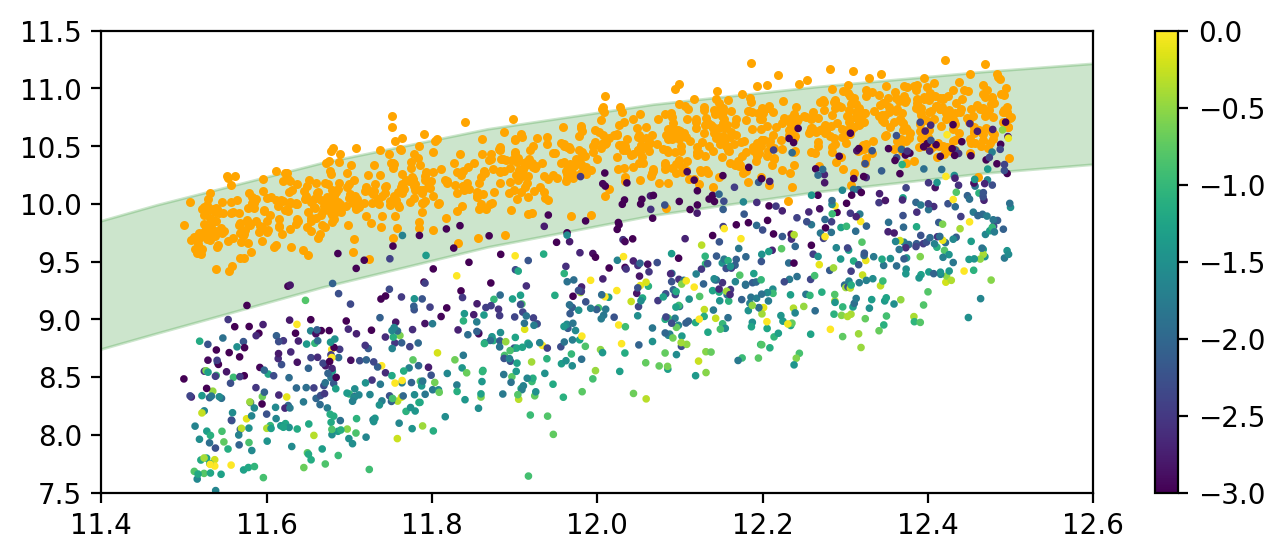

In [201]:
pl.figure(figsize=(8,3))
pl.scatter(np.log10(root_mass),np.log10(mstar_main_all),s=5,c='orange')

pl.scatter(np.log10(root_mass),np.log10(m_acc+m_streams),s=3,c=np.log10(m_streams/m_acc),
           alpha=1,vmin=-3,vmax=0)
pl.colorbar()

ax = pl.gca()
plot_b18(ax=ax,h=0.73)

pl.xlim(11.4,12.6)
pl.ylim(7.5,11.5)
xx = np.arange(10,13,0.1)
#pl.plot(xx,xx,c='k',ls='--')
#pl.plot(xx,xx+np.log10(0.7),c='k',ls='--',alpha=0.1)
#pl.plot(xx,xx+np.log10(0.1),c='k',ls='--',alpha=0.1);

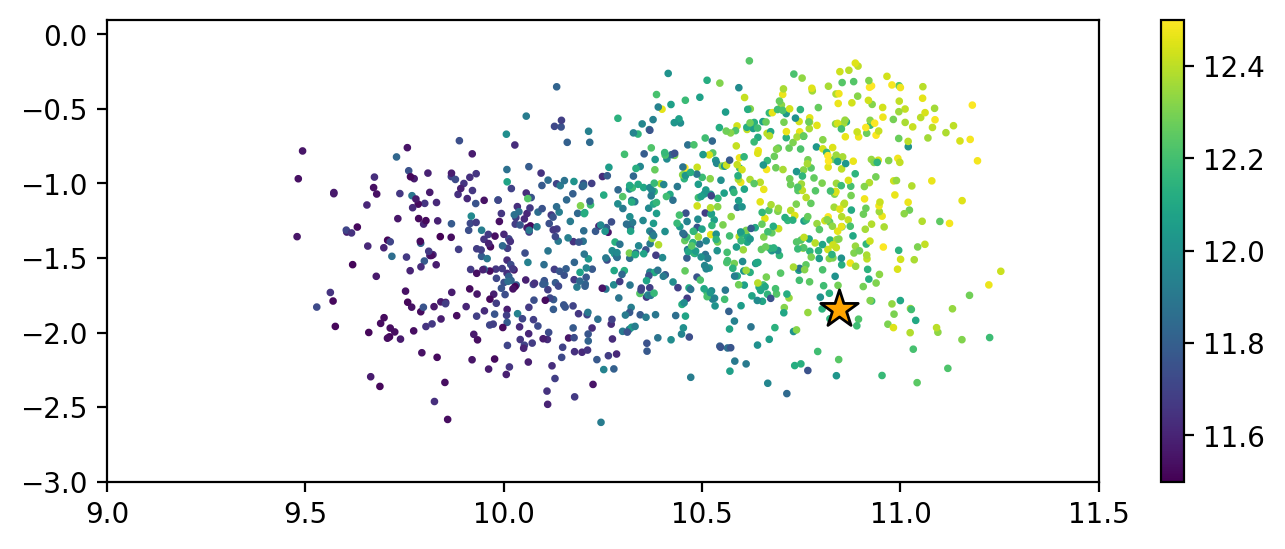

In [202]:
pl.figure(figsize=(8,3))

sm = pl.scatter(np.log10(mstar_main_with_acc),np.log10((m_acc+m_streams)/mstar_main_with_acc),s=3,c=np.log10(root_mass),
           alpha=1,vmin=11.5,vmax=12.5)

pl.scatter(np.log10(7e10),np.log10(1e9/7e10),marker='*',s=200,color='orange',edgecolor='k')
pl.colorbar(sm)

ax = pl.gca()
plot_b18(ax=ax,h=0.73)

pl.xlim(9.0,11.5)
pl.ylim(-3,0.1)
xx = np.arange(10,13,0.1)
#pl.plot(xx,xx,c='k',ls='--')
#pl.plot(xx,xx+np.log10(0.7),c='k',ls='--',alpha=0.1)
#pl.plot(xx,xx+np.log10(0.1),c='k',ls='--',alpha=0.1);

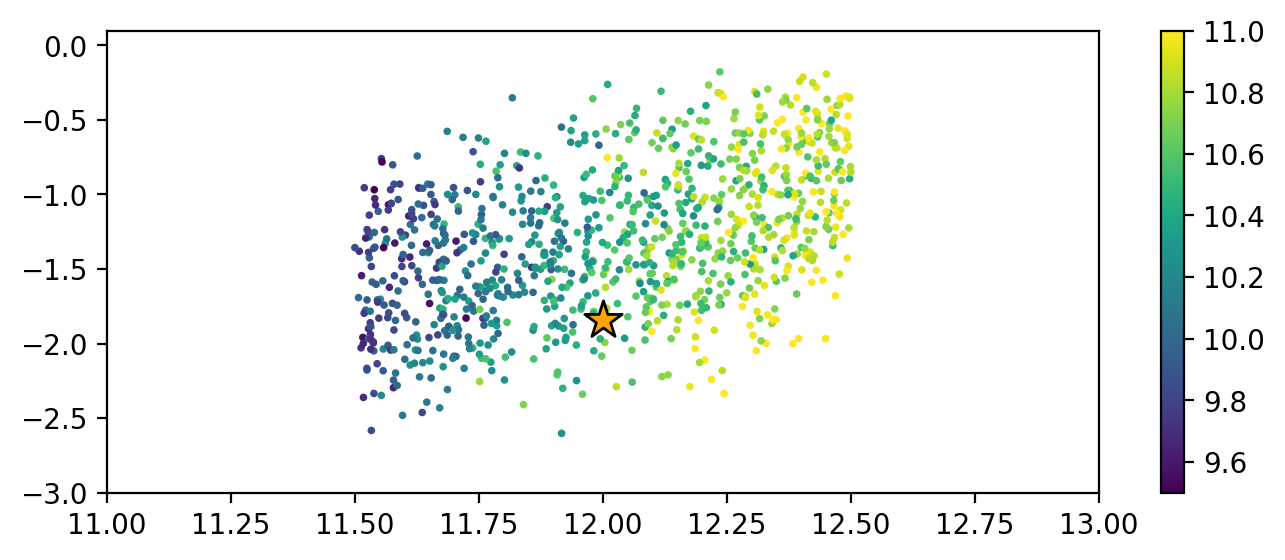

In [203]:
pl.figure(figsize=(8,3))

sm = pl.scatter(np.log10(root_mass),np.log10((m_acc+m_streams)/mstar_main_with_acc),s=3,c=np.log10(mstar_main_with_acc),
           alpha=1,vmin=9.5,vmax=11.0)

pl.scatter(np.log10(1e12),np.log10(1e9/7e10),marker='*',s=200,color='orange',edgecolor='k')
pl.colorbar(sm)

ax = pl.gca()
plot_b18(ax=ax,h=0.73)

pl.xlim(11.0,13.0)
pl.ylim(-3,0.1)
xx = np.arange(10,13,0.1)
#pl.plot(xx,xx,c='k',ls='--')
#pl.plot(xx,xx+np.log10(0.7),c='k',ls='--',alpha=0.1)
#pl.plot(xx,xx+np.log10(0.1),c='k',ls='--',alpha=0.1);

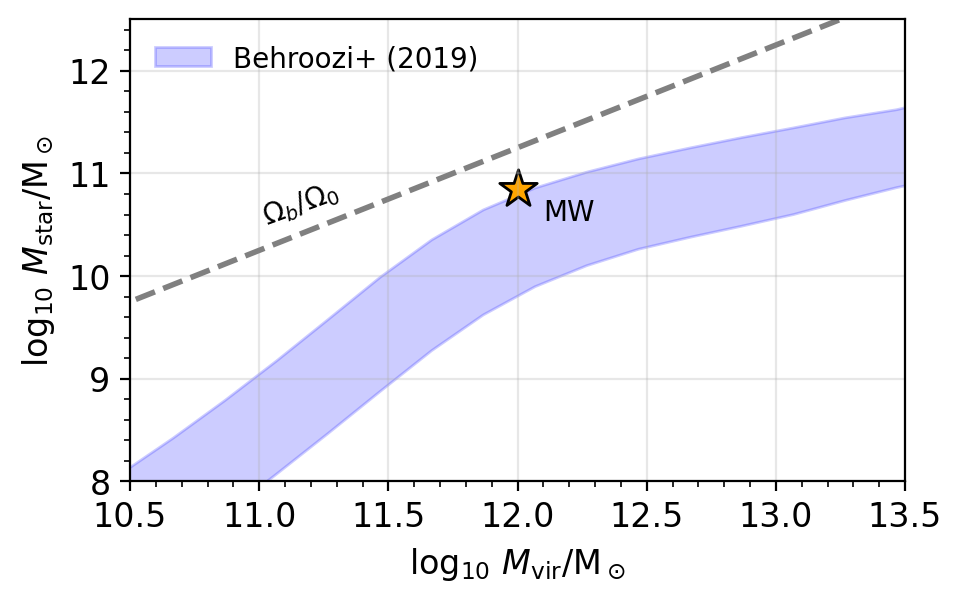

In [272]:
pl.figure(figsize=(5,3))
ax = pl.gca()
plot_b18(ax=ax,h=0.73,c='blue')

OMEGA_B = 0.04455
OMEGA_0 = 0.25
baryon_mass_fraction = OMEGA_B/OMEGA_0 
xx = np.arange(8,14,0.1)
yy = xx+np.log10(baryon_mass_fraction)
pl.plot(xx,yy,c='grey',lw=2,ls='--')

pl.scatter([12],[np.log10(7e10)],c='orange', marker='*', edgecolor='k', s=200)
pl.text(12.1,np.log10(7e10)-0.3,'MW',color='k')

pl.text(11,10.5,'$\Omega_{b}/\Omega_0$',rotation=20,color='k')

pl.xlim(10.5,13.5)
pl.ylim(8,12.5)

xx = np.arange(10,13.5,0.1)

pl.ylabel('$\log_{10}\,M_\mathrm{star}/\mathrm{M_\odot}$',fontsize=12)
pl.xlabel('$\log_{10}\,M_\mathrm{vir}/\mathrm{M_\odot}$',fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.minorticks_on()
pl.grid(alpha=0.3)
pl.legend(frameon=False);

#pl.plot(xx,xx,c='k',ls='--')
#pl.plot(xx,xx+np.log10(0.7),c='k',ls='--',alpha=0.1)
#pl.plot(xx,xx+np.log10(0.1),c='k',ls='--',alpha=0.1);

path = './figs/smhm_simple.png'
pl.savefig(path,bbox_inches='tight',pad_inches=0.1,dpi=300)

In [205]:
"%e"%(mstar_main_all.min())

'2.599354e+09'

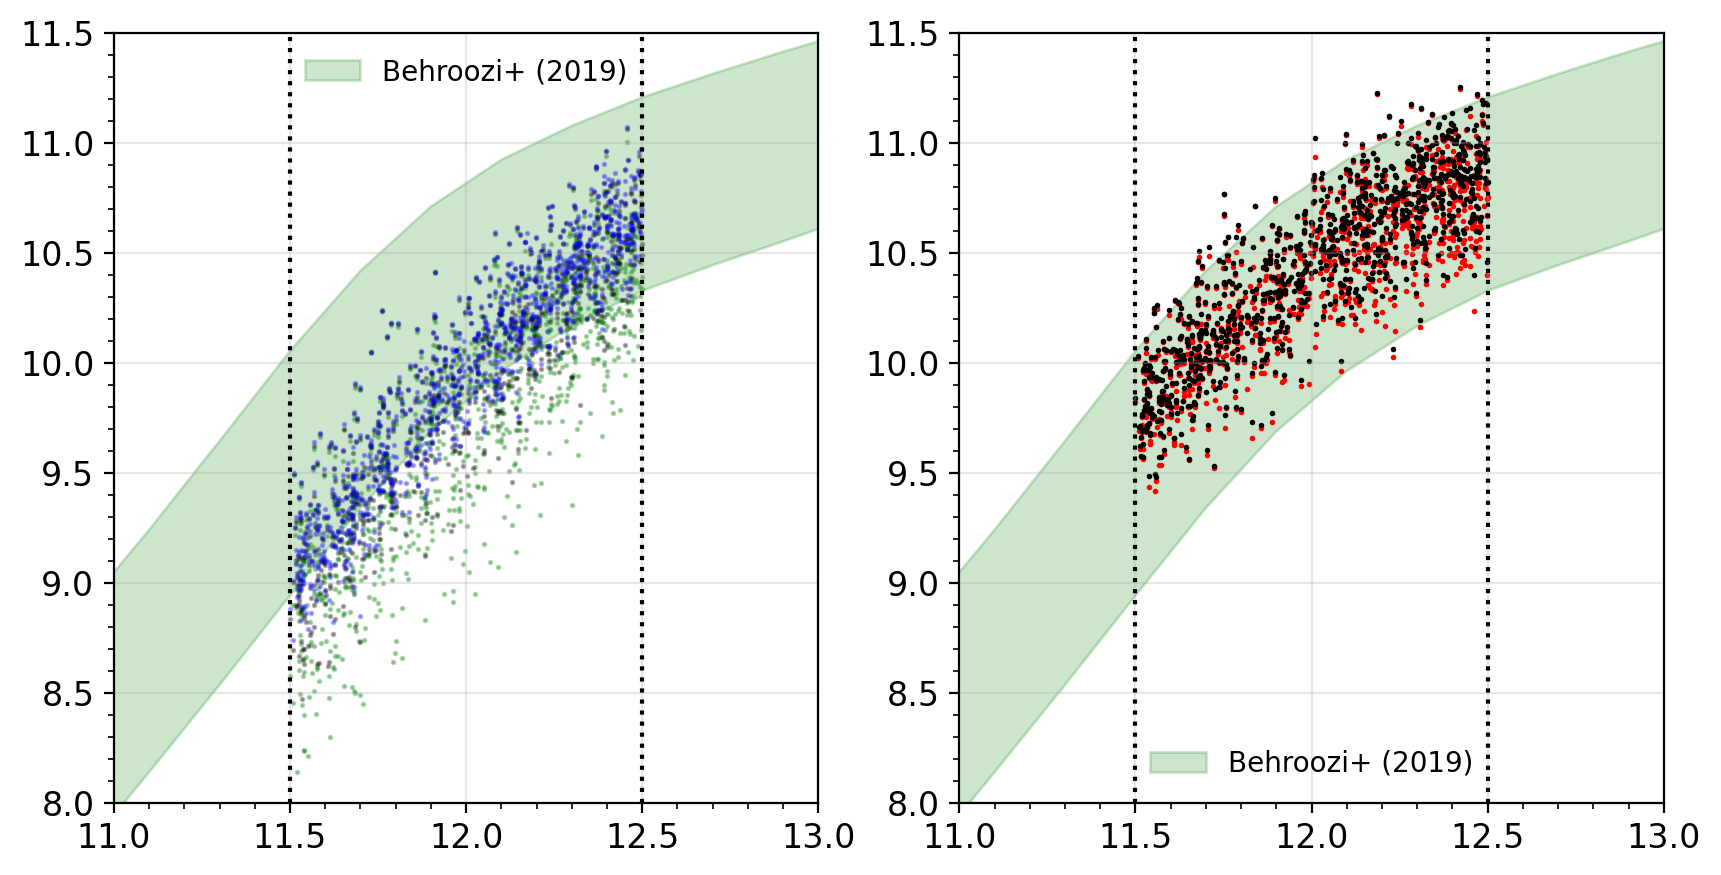

In [206]:
pl.figure(figsize=(10,5))

ax1 = pl.subplot(1,2,1)
pl.scatter(np.log10(root_mass),np.log10(mstar_main_smooth),c='g',s=1,alpha=0.3)
pl.scatter(np.log10(root_mass),np.log10(mstar_main_smooth+m_acc+m_streams),c='k',s=1,alpha=0.3)
pl.scatter(np.log10(root_mass),np.log10(mstar_main_smooth+m_acc_with_sats),c='b',s=1,alpha=0.3)

plot_b18(ax1)

ax2 = pl.subplot(1,2,2)
pl.scatter(np.log10(root_mass),np.log10(mstar_main_all),c='r',s=1)
pl.scatter(np.log10(root_mass),np.log10(mstar_main_all+(m_acc+m_streams)),c='k',s=1)

plot_b18(ax2)

for ax in [ax1,ax2]:
    pl.sca(ax)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.minorticks_on()
    pl.grid(alpha=0.3)
    pl.legend(frameon=False)
    pl.axvline(11.5,ls=':',c='k')
    pl.axvline(12.5,ls=':',c='k')
    pl.ylim(8,11.5)
    pl.xlim(11,13);

In [207]:
# Z=0 Mvir -> Mstar, including the accreted mass
mstar_sel = mstar_main_all+m_acc+m_streams
mw_by_mstar_all_in = (np.log10(mstar_sel) > 10.0) & (np.log10(mstar_sel) < np.log10(5e10))

In [208]:
f_star_lost = 1 - final_mstar/initial_mstar

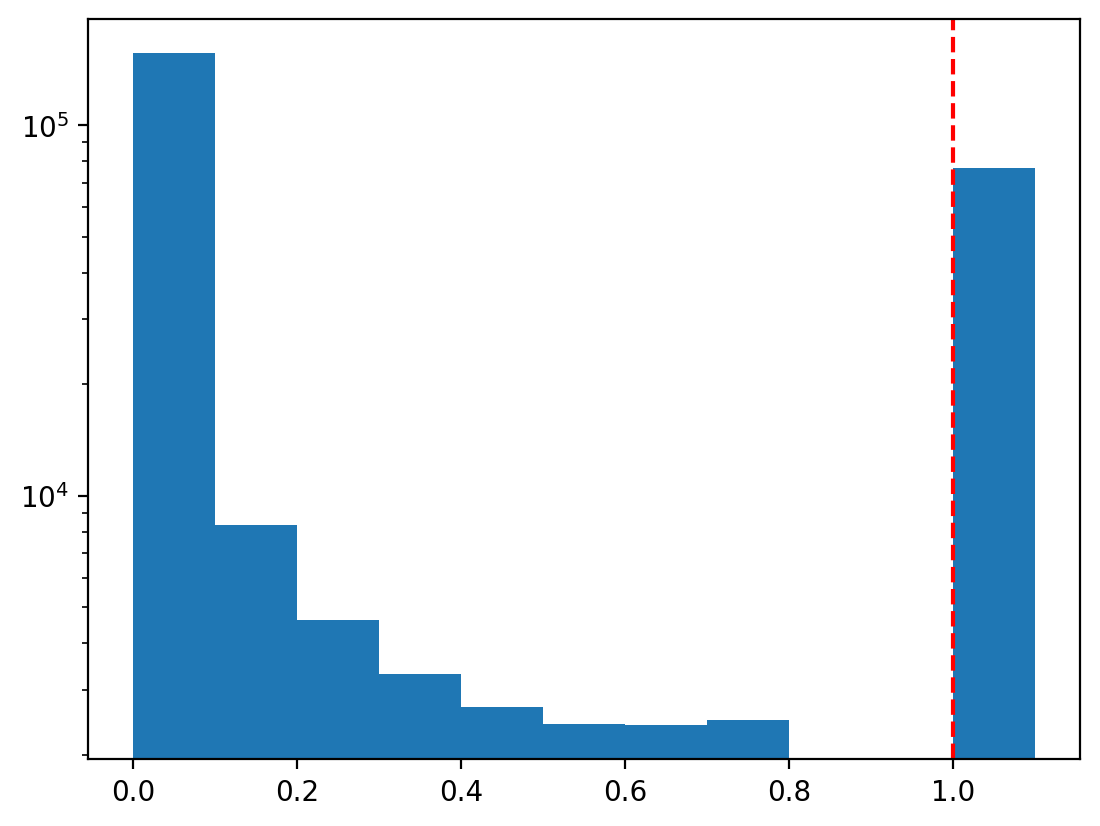

In [209]:
_f_star_lost = f_star_lost.copy()
_f_star_lost[_f_star_lost >= 0.8] = 1.1
pl.hist(_f_star_lost,bins=np.arange(0,1.2,0.1),log=True);
pl.axvline(1,c='r',ls='--');

Text(0.5, 0, '$\\log_{10}\\,M_\\mathrm{p,ini}/\\mathrm{M_\\odot}$')

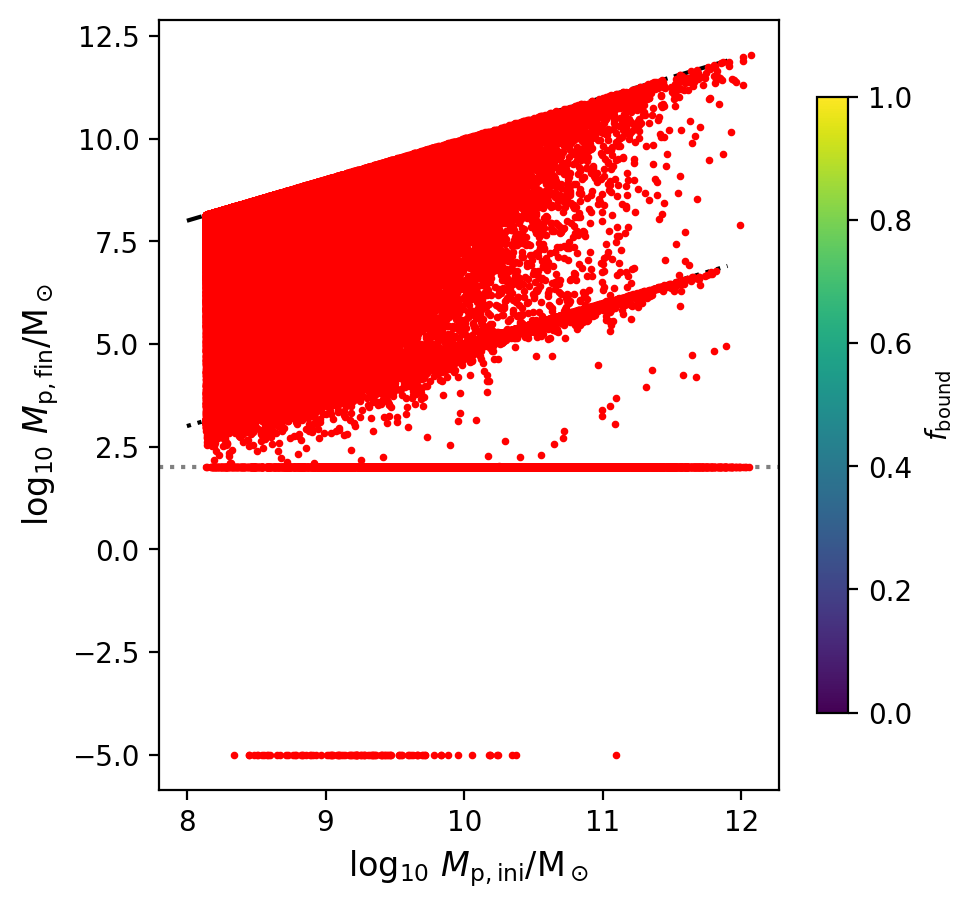

In [210]:
pl.figure(figsize=(5,5))

itree  = 0
    
pl.scatter(np.log10(initial_mass), np.log10(final_mass), vmin=0, vmax=1, s=3, zorder=10, c='r')
pl.colorbar(shrink=0.8,label='$f_\mathrm{bound}$')

# 1:1 line
xx = np.arange(8,12,0.1)
pl.plot(xx,xx,c='k',ls='--')

# Relative threshold in satgen
xx = np.arange(8,12,0.1)
pl.plot(xx,xx + np.log10(cfg.psi_res),c='k',ls=':');

# Absolute threshold in satgen
pl.axhline(np.log10(cfg.Mres),ls=':',c='grey')

pl.ylabel('$\log_{10}\,M_\mathrm{p,fin}/\mathrm{M_\odot}$',fontsize=12)
pl.xlabel('$\log_{10}\,M_\mathrm{p,ini}/\mathrm{M_\odot}$',fontsize=12)

In [211]:
def plot_koposov_cmf(ax):
    """
    Thanks GPT
    """
    # Constants
    Upsilon_V = 1.5  # stellar mass-to-light ratio
    Mv_sun    = 4.83

    # Define Mv range from -13 (bright) to -2 (faint)
    Mv = np.linspace(-13, -2, 1000)

    # Koposov differential LF
    dNdMv = 10 * 10**(0.1 * (Mv + 5))

    # Convert Mv to stellar mass
    logM_star = np.log10(Upsilon_V) - 0.4 * (Mv - Mv_sun)
    M_star = 10**logM_star

    # Sort increasing mass
    sort_idx = np.argsort(M_star)
    M_star = M_star[sort_idx]
    dNdMv = dNdMv[sort_idx]

    # Compute dlogM/dMv to convert to dN/dlogM
    dlogM_dMv = -0.4 / np.log(10)
    dNdlogM = dNdMv / np.abs(dlogM_dMv)

    # Estimate bin widths
    logM = np.log10(M_star)
    dlogM = np.gradient(logM)
    N_bin = dNdlogM * dlogM

    # Cumulative number: number of satellites with M_* > X
    N_cumulative = np.cumsum(N_bin[::-1])[::-1]

    ax.plot(np.log10(M_star), np.log10(N_cumulative), label='Koposov+08 (converted to mass)')
    return

In [282]:
def plot_saga_cmf(ax,label=None):
    """
    """
    # Table C5 from Mao 2024
    saga_sat_mf = np.array([
    (10.31 , 0.026),
    (9.94  , 0.185),
    (9.56  , 0.475),
    (9.19  , 0.475),
    (8.81  , 0.820),
    (8.44  , 1.041),
    (8.06  , 1.524),
    (7.69  , 2.304),
    (7.31  , 3.111),
    (6.94  , 5.950),
    (6.56  , 4.376)])

    saga_lmstar = saga_sat_mf[:,0]
    saga_count  = saga_sat_mf[:,1]

    # SAGA
    # The bin width is either 0.37 or 0.38

    # The bins are in log Mstar
    BIN_WIDTH  = 0.37
    BIN_HWIDTH = BIN_WIDTH/2.0
    BIN_EDGES  = np.concatenate([saga_lmstar - BIN_HWIDTH, [saga_lmstar[-1]+BIN_HWIDTH]])

    # We take the given masses as midpoints of bins
    # Reverse order to get low to high
    saga_lmstar = saga_sat_mf[:,0][::-1]

    # The counts are in dN/dlogM
    # Reverse order to get low to high
    saga_dNdlogM = saga_sat_mf[:,1][::-1]

    saga_N_bin   = saga_dNdlogM*BIN_WIDTH
    saga_N_bin_c = np.cumsum(saga_N_bin[::-1])[::-1]
    ax.plot(saga_lmstar,np.log10(saga_N_bin_c),label=label,c='g',lw=2)
    return

In [213]:
def plot_dw_2020_cmf(ax,label=None):
    """
    """
    Upsilon_V = 1.5  # stellar mass-to-light ratio
    Mv_sun    = 4.83   
    dw  = Table.read('/lfs/data/apcooper/projects/obsdata/dw2020/dw2020_mw_cor_lf.csv',
                    format='ascii')
    # Missing - in table
    M_V = -dw['MV']

    logM_star = np.log10(Upsilon_V) - 0.4 * (M_V - Mv_sun)
    ax.plot(logM_star, np.log10(dw['NMV']), drawstyle='steps-pre',c='k',label=label)
    return

In [214]:
u_tree_idx, u_idx, u_inv = np.unique(tree_idx,return_inverse=True,return_index=True)
ntrees = len(u_tree_idx)

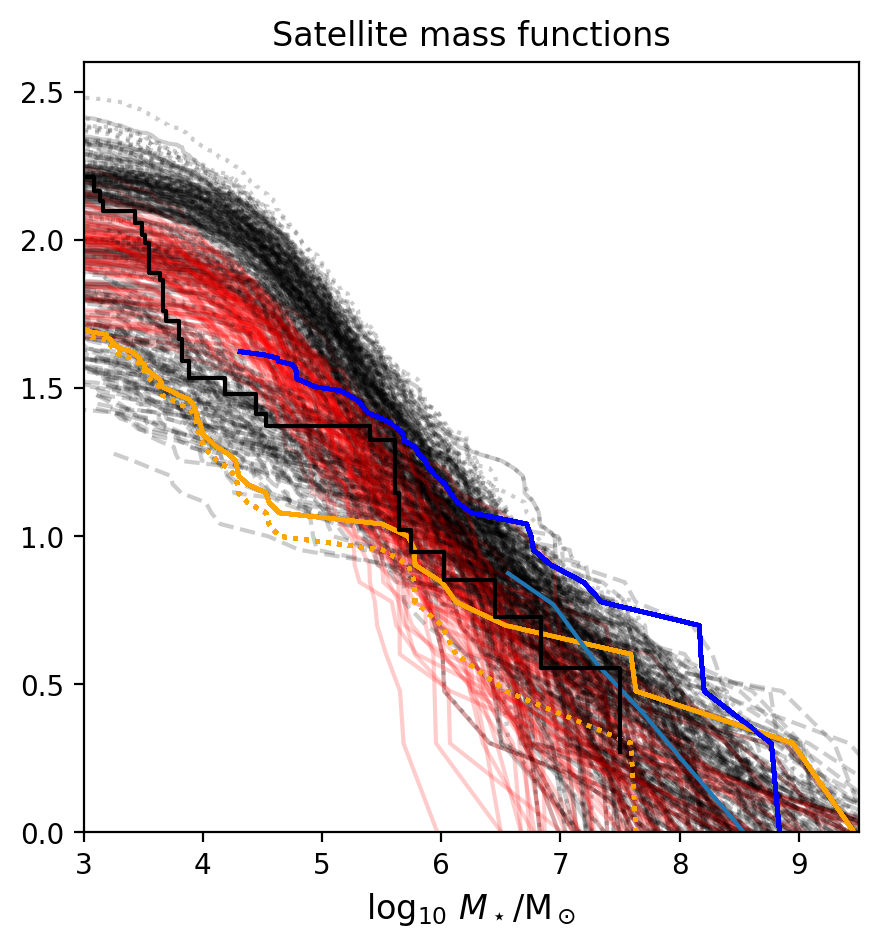

In [215]:
R_LIMIT = 200.0 # kpc

lvd_pace = '/data/apcooper/sfw/local_volume_database/data/dwarf_mw.csv'
mw_sats  = Table.read(lvd_pace)
mw_sats_mstar = mw_sats['mass_stellar'].data

mw_sats_rgc   = mw_sats['distance_host']
mw_sats_mstar = mw_sats_mstar[mw_sats_rgc < R_LIMIT]

lvd_pace = '/data/apcooper/sfw/local_volume_database/data/dwarf_m31.csv'
m31_sats  = Table.read(lvd_pace)
m31_sats_mstar = m31_sats['mass_stellar'].data

pl.figure(figsize=(5,5))

s = (np.log10(root_mass) > 11.95) & (np.log10(root_mass) < 12.05)

for itree in range(0,ntrees):
    if not s[itree]:
        continue
        
    this_tree = np.flatnonzero(tree_idx == itree)
    
    mstar_fin_all = final_mstar[this_tree]
    mstar_ini_all = initial_mstar[this_tree]
    mass_fin_all  = final_mass[this_tree]
    mass_ini_all  = initial_mass[this_tree]
    
    r_fin_all     = final_radius[this_tree]

    f_star_bound = mstar_fin_all/mstar_ini_all
    f_mass_bound = mass_fin_all/mass_ini_all
    
    survives     = (mass_fin_all > cfg.Mres) & (f_mass_bound > cfg.psi_res)

    is_in_rvir   = r_fin_all < R_LIMIT
    
    mstar_surv = mstar_fin_all[survives]
    mstar_disr = mstar_ini_all[~survives]
    
    mstar_surv_rvir = mstar_fin_all[survives & is_in_rvir]
    
    mstar_surv_orig = mstar_ini_all[survives]
    
    # Cumulative mass functions
    
    x  = mstar_surv
    nx = len(x)
    x_sort = np.argsort(x)
    _p = pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),c='k',alpha=0.2)
    _c = _p[0].get_c()
    
    x  = mstar_surv_rvir
    nx = len(x)
    x_sort = np.argsort(x)
    _p = pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),c='r',alpha=0.2)
     
    x  = mstar_surv_orig
    nx = len(x)
    x_sort = np.argsort(x)
    _p = pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),ls=':',c=_c,alpha=0.2)
    
    x  = mstar_disr
    nx = len(x)
    x_sort = np.argsort(x)
    pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),ls='--',c=_c,alpha=0.2)

    x  = 10**mw_sats_mstar
    nx = len(x)
    x_sort = np.argsort(x)
    pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),ls='solid',c='orange',alpha=1)
    
    x  = 10**mw_sats_mstar
    nx = len(x)
    x_sort = np.argsort(x)
    pl.plot(np.log10(x[x_sort][:-2]),np.log10(np.arange(nx-2,0,-1)),ls=':',c='orange',alpha=1)
    
    
    x  = 10**m31_sats_mstar
    nx = len(x)
    x_sort = np.argsort(x)
    pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),ls='solid',c='b',alpha=1)
    
plot_saga_cmf(pl.gca())
#plot_koposov_cmf(pl.gca())
plot_dw_2020_cmf(pl.gca())

pl.xlim(3,9.5)
pl.ylim(0,  2.6)
pl.xlabel('$\log_{10}\,M_\star/\mathrm{M_\odot}$',fontsize=12)
pl.title('Satellite mass functions');

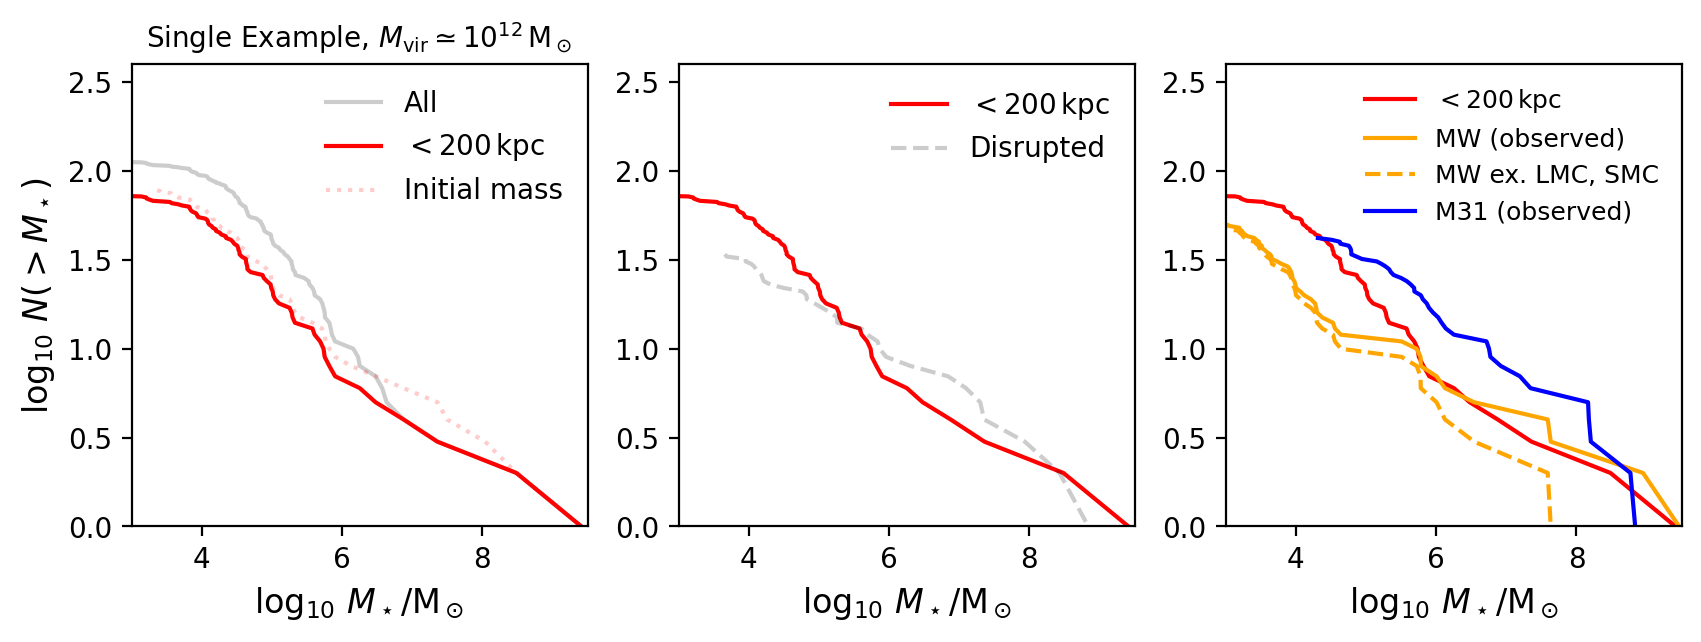

In [277]:
R_LIMIT = 200.0 # kpc

lvd_pace = '/data/apcooper/sfw/local_volume_database/data/dwarf_mw.csv'
mw_sats  = Table.read(lvd_pace)
mw_sats_mstar = mw_sats['mass_stellar'].data

mw_sats_rgc   = mw_sats['distance_host']
mw_sats_mstar = mw_sats_mstar[mw_sats_rgc < R_LIMIT]

lvd_pace = '/data/apcooper/sfw/local_volume_database/data/dwarf_m31.csv'
m31_sats  = Table.read(lvd_pace)
m31_sats_mstar = m31_sats['mass_stellar'].data

pl.figure(figsize=(10,3))
ax1 = pl.subplot(1,3,1)
ax2 = pl.subplot(1,3,2)
ax3 = pl.subplot(1,3,3)
    
# Select MW-like halo mass
s = (np.log10(root_mass) > 11.99) & (np.log10(root_mass) < 12.01)
itrees_mw = np.flatnonzero(s)
    
# Plot one example
for itree in [itrees_mw[3]]:
    
    this_tree = np.flatnonzero(tree_idx == itree)
    
    mstar_fin_all = final_mstar[this_tree]
    mstar_ini_all = initial_mstar[this_tree]
    mass_fin_all  = final_mass[this_tree]
    mass_ini_all  = initial_mass[this_tree]
    
    r_fin_all     = final_radius[this_tree]

    f_star_bound = mstar_fin_all/mstar_ini_all
    f_mass_bound = mass_fin_all/mass_ini_all
    
    survives     = (mass_fin_all > cfg.Mres) & (f_mass_bound > cfg.psi_res)

    is_in_rvir   = r_fin_all < R_LIMIT

    outside_central_zone  = r_fin_all > 60.0
    
    mstar_surv = mstar_fin_all[survives]
    mstar_disr = mstar_ini_all[~survives]
    
    # Only count surviving satellites within 200kpc
    mstar_surv_rvir = mstar_fin_all[survives & is_in_rvir]
    
    # Ignore central few kpc
    mstar_surv_rvir_outer = mstar_fin_all[survives & is_in_rvir & outside_central_zone]
        
    # Using original mass rather than present mass and within 200kpc
    mstar_surv_orig = mstar_ini_all[survives & is_in_rvir]
    
    #### PLOT Cumulative mass functions
    
    pl.sca(ax1)
    # - Surviving mass, all satellites
    x  = mstar_surv
    nx = len(x)
    x_sort = np.argsort(x)
    _p = pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),c='k',ls='solid',alpha=0.2,label='All')
    _c = _p[0].get_c()
    
    # - Surviving mass, within rvir
    x  = mstar_surv_rvir
    nx = len(x)
    x_sort = np.argsort(x)
    _p = pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),c='r',alpha=1,label='$<200\,\mathrm{kpc}$')
     
    # - Original mass, within rvir
    x  = mstar_surv_orig
    nx = len(x)
    x_sort = np.argsort(x)
    _p = pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),ls=':',c='r',alpha=0.2,label='Initial mass')
    
    pl.legend(frameon=False,fontsize=10)
    
    ## Difference between surviving and disrupted
    pl.sca(ax2)
    
    # - Surviving mass, within rvir
    x  = mstar_surv_rvir
    nx = len(x)
    x_sort = np.argsort(x)
    _p = pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),c='r',alpha=1,label='$<200\,\mathrm{kpc}$')
     
    # - Surviving mass, within rvir, outside some raidus
    #x  = mstar_surv_rvir_outer
    #nx = len(x)
    #x_sort = np.argsort(x)
    #_p = pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),c='y',alpha=1,label='$<200\,\mathrm{kpc}$')
        
    # - Disrupted mass
    x  = mstar_disr
    nx = len(x)
    x_sort = np.argsort(x)
    pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),ls='--',c=_c,alpha=0.2,label='Disrupted')

    pl.legend(frameon=False,fontsize=10)

    ## Observations
    pl.sca(ax3)

    # - Surviving mass, within rvir
    x  = mstar_surv_rvir
    nx = len(x)
    x_sort = np.argsort(x)
    _p = pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),c='r',alpha=1,label='$<200\,\mathrm{kpc}$')
           
    x  = 10**mw_sats_mstar
    nx = len(x)
    x_sort = np.argsort(x)
    pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),ls='solid',c='orange',alpha=1,label='MW (observed)')
    
    x  = 10**mw_sats_mstar
    nx = len(x)
    x_sort = np.argsort(x)
    pl.plot(np.log10(x[x_sort][:-2]),np.log10(np.arange(nx-2,0,-1)),ls='--',c='orange',alpha=1,label='MW ex. LMC, SMC')
    
    x  = 10**m31_sats_mstar
    nx = len(x)
    x_sort = np.argsort(x)
    pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),ls='solid',c='b',alpha=1,label='M31 (observed)')
    
    #plot_saga_cmf(pl.gca())
    #plot_koposov_cmf(pl.gca())
    #plot_dw_2020_cmf(pl.gca())
    
    pl.legend(frameon=False,fontsize=9)

# Plot a few more examples on ax 2:
if False:
    pl.sca(ax2)
    for itree in itrees_mw[1:4]:
        this_tree = np.flatnonzero(tree_idx == itree)

        mstar_fin_all = final_mstar[this_tree]
        mstar_ini_all = initial_mstar[this_tree]
        mass_fin_all  = final_mass[this_tree]
        mass_ini_all  = initial_mass[this_tree]

        r_fin_all     = final_radius[this_tree]

        f_star_bound = mstar_fin_all/mstar_ini_all
        f_mass_bound = mass_fin_all/mass_ini_all

        survives     = (mass_fin_all > cfg.Mres) & (f_mass_bound > cfg.psi_res)

        is_in_rvir   = r_fin_all < R_LIMIT

        mstar_surv = mstar_fin_all[survives]
        mstar_disr = mstar_ini_all[~survives]

        # Only count surviving satellites within 200kpc
        mstar_surv_rvir = mstar_fin_all[survives & is_in_rvir]

        # Using original mass rather than present mass and within 200kpc
        mstar_surv_orig = mstar_ini_all[survives & is_in_rvir]

        # - Surviving mass, within rvir
        x  = mstar_surv_rvir
        nx = len(x)
        x_sort = np.argsort(x)
        _p = pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),c='r',alpha=0.2,label='$<200\,\mathrm{kpc}$')

        # - Disrupted mass
        x  = mstar_disr
        nx = len(x)
        x_sort = np.argsort(x)
        pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),ls='--',c=_c,alpha=0.2,label='Disrupted')

for ax in [ax1,ax2,ax3]:
    pl.sca(ax)
    pl.xlim(3,9.5)
    pl.ylim(0,2.6)
    pl.xlabel('$\log_{10}\,M_\star/\mathrm{M_\odot}$',fontsize=12)
    
pl.sca(ax1)
pl.title('Single Example, $M_\mathrm{vir}\simeq10^{12}\,\mathrm{M_\odot}$',fontsize=10);
pl.ylabel('$\log_{10}\,N(>M_\star)$',fontsize=12)

path = './figs/satellite_lw_mw_example_logmass_range_set.png'
pl.savefig(path,bbox_inches='tight',pad_inches=0.1,dpi=300)

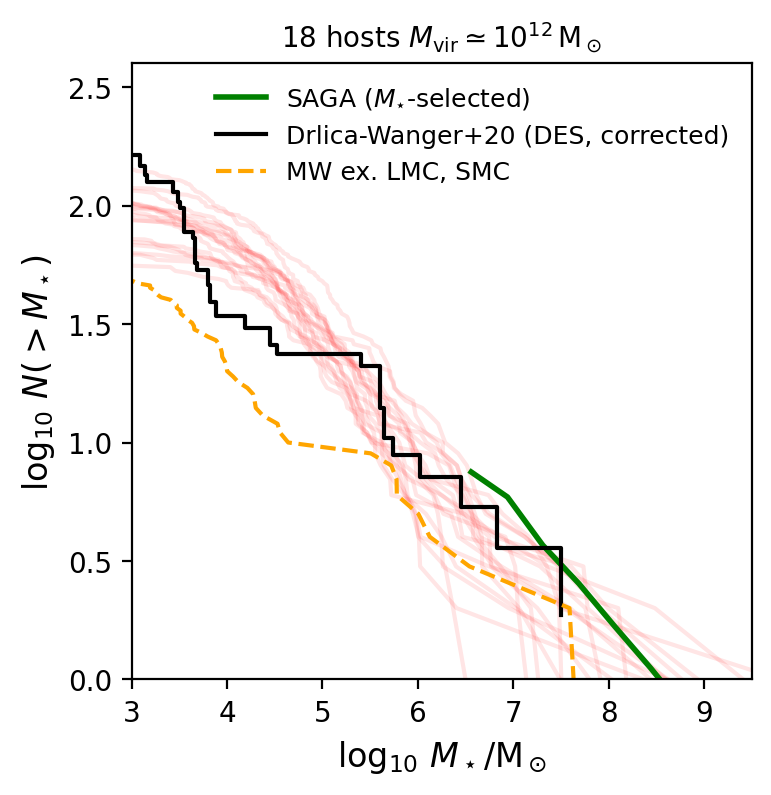

In [283]:
R_LIMIT = 200.0 # kpc

lvd_pace = '/data/apcooper/sfw/local_volume_database/data/dwarf_mw.csv'
mw_sats  = Table.read(lvd_pace)
mw_sats_mstar = mw_sats['mass_stellar'].data

mw_sats_rgc   = mw_sats['distance_host']
mw_sats_mstar = mw_sats_mstar[mw_sats_rgc < R_LIMIT]

lvd_pace = '/data/apcooper/sfw/local_volume_database/data/dwarf_m31.csv'
m31_sats  = Table.read(lvd_pace)
m31_sats_mstar = m31_sats['mass_stellar'].data

pl.figure(figsize=(4,4))
ax1 = pl.subplot(1,1,1)

# Select MW-like halo mass
s = (np.log10(root_mass) > 11.99) & (np.log10(root_mass) < 12.01)
itrees_mw = np.flatnonzero(s)
    
# Plot one example
for itree in itrees_mw:
    
    this_tree = np.flatnonzero(tree_idx == itree)
    
    mstar_fin_all = final_mstar[this_tree]
    mstar_ini_all = initial_mstar[this_tree]
    mass_fin_all  = final_mass[this_tree]
    mass_ini_all  = initial_mass[this_tree]
    
    r_fin_all     = final_radius[this_tree]

    f_star_bound = mstar_fin_all/mstar_ini_all
    f_mass_bound = mass_fin_all/mass_ini_all
    
    survives     = (mass_fin_all > cfg.Mres) & (f_mass_bound > cfg.psi_res)

    is_in_rvir   = r_fin_all < R_LIMIT
    
    mstar_surv = mstar_fin_all[survives]
    mstar_disr = mstar_ini_all[~survives]
    
    # Only count surviving satellites within 200kpc
    mstar_surv_rvir = mstar_fin_all[survives & is_in_rvir]
    
    # Using original mass rather than present mass and within 200kpc
    mstar_surv_orig = mstar_ini_all[survives & is_in_rvir]
    
    #### PLOT Cumulative mass functions
    
    pl.sca(ax1)
      
    # - Surviving mass, within rvir
    x  = mstar_surv_rvir
    nx = len(x)
    x_sort = np.argsort(x)
    _p = pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),c='r',alpha=0.1)

plot_saga_cmf(pl.gca(),label='SAGA ($M_{\star}$-selected)')
#plot_koposov_cmf(pl.gca())
plot_dw_2020_cmf(pl.gca(),label='Drlica-Wanger+20 (DES, corrected)')    
    
x  = 10**mw_sats_mstar
nx = len(x)
x_sort = np.argsort(x)
pl.plot(np.log10(x[x_sort][:-2]),np.log10(np.arange(nx-2,0,-1)),ls='--',c='orange',alpha=1,label='MW ex. LMC, SMC')

    
pl.xlim(3,9.5)
pl.ylim(0,2.6)
pl.xlabel('$\log_{10}\,M_\star/\mathrm{M_\odot}$',fontsize=12)
pl.ylabel('$\log_{10}\,N(>M_\star)$',fontsize=12)

pl.title('{:d} hosts $M_\mathrm{{vir}}\simeq10^{{12}}\,\mathrm{{M_\odot}}$'.format(len(itrees_mw)),fontsize=10);
pl.legend(frameon=False,fontsize=9)

path = './figs/satellite_lf_all_mws_with_obs_logmass_range_set.png'
pl.savefig(path,bbox_inches='tight',pad_inches=0.1,dpi=300)

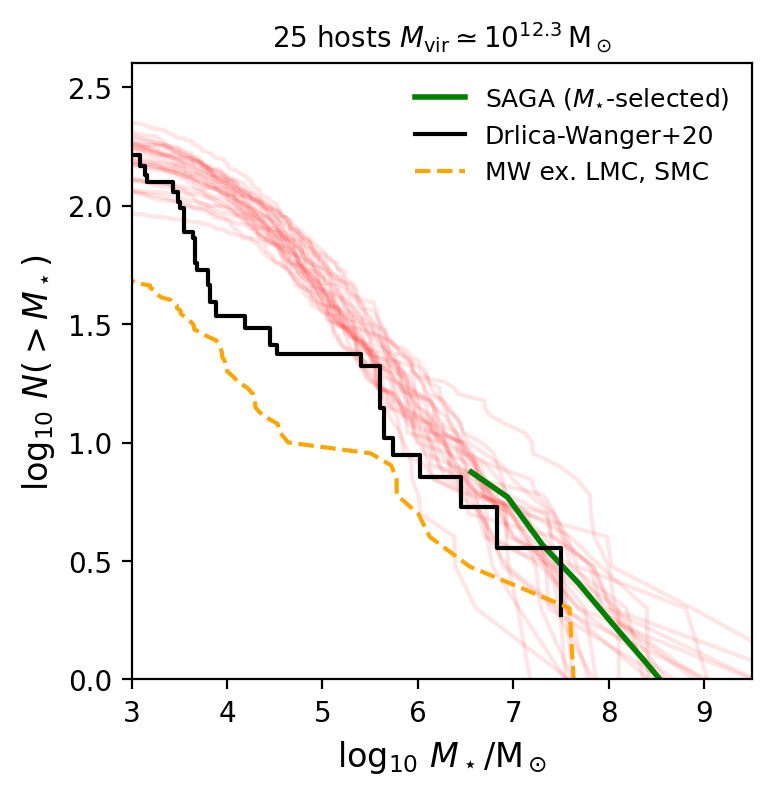

In [284]:
R_LIMIT = 200.0 # kpc

lvd_pace = '/data/apcooper/sfw/local_volume_database/data/dwarf_mw.csv'
mw_sats  = Table.read(lvd_pace)
mw_sats_mstar = mw_sats['mass_stellar'].data

mw_sats_rgc   = mw_sats['distance_host']
mw_sats_mstar = mw_sats_mstar[mw_sats_rgc < R_LIMIT]

lvd_pace = '/data/apcooper/sfw/local_volume_database/data/dwarf_m31.csv'
m31_sats  = Table.read(lvd_pace)
m31_sats_mstar = m31_sats['mass_stellar'].data

pl.figure(figsize=(4,4))
ax1 = pl.subplot(1,1,1)

# Select super-MW-like halo mass
s = (np.log10(root_mass) > 12.29) & (np.log10(root_mass) < 12.31)
itrees_mw = np.flatnonzero(s)
    
# Plot one example
for itree in itrees_mw:
    
    this_tree = np.flatnonzero(tree_idx == itree)
    
    mstar_fin_all = final_mstar[this_tree]
    mstar_ini_all = initial_mstar[this_tree]
    mass_fin_all  = final_mass[this_tree]
    mass_ini_all  = initial_mass[this_tree]
    
    r_fin_all     = final_radius[this_tree]

    f_star_bound = mstar_fin_all/mstar_ini_all
    f_mass_bound = mass_fin_all/mass_ini_all
    
    survives     = (mass_fin_all > cfg.Mres) & (f_mass_bound > cfg.psi_res)

    is_in_rvir   = r_fin_all < R_LIMIT
    
    mstar_surv = mstar_fin_all[survives]
    mstar_disr = mstar_ini_all[~survives]
    
    # Only count surviving satellites within 200kpc
    mstar_surv_rvir = mstar_fin_all[survives & is_in_rvir]
    
    # Using original mass rather than present mass and within 200kpc
    mstar_surv_orig = mstar_ini_all[survives & is_in_rvir]
    
    #### PLOT Cumulative mass functions
    
    pl.sca(ax1)
      
    # - Surviving mass, within rvir
    x  = mstar_surv_rvir
    nx = len(x)
    x_sort = np.argsort(x)
    _p = pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),c='r',alpha=0.1)

plot_saga_cmf(pl.gca(),label='SAGA ($M_{\star}$-selected)')
#plot_koposov_cmf(pl.gca())
plot_dw_2020_cmf(pl.gca(),label='Drlica-Wanger+20')    
    
x  = 10**mw_sats_mstar
nx = len(x)
x_sort = np.argsort(x)
pl.plot(np.log10(x[x_sort][:-2]),np.log10(np.arange(nx-2,0,-1)),ls='--',c='orange',alpha=1,label='MW ex. LMC, SMC')

    
pl.xlim(3,9.5)
pl.ylim(0,2.6)
pl.xlabel('$\log_{10}\,M_\star/\mathrm{M_\odot}$',fontsize=12)
pl.ylabel('$\log_{10}\,N(>M_\star)$',fontsize=12)

pl.title('{:d} hosts $M_\mathrm{{vir}}\simeq10^{{12.3}}\,\mathrm{{M_\odot}}$'.format(len(itrees_mw)),fontsize=10);
pl.legend(frameon=False,fontsize=9)

path = './figs/satellite_lf_bigger_halo_mws_with_obs_logmass_range_set.png'
pl.savefig(path,bbox_inches='tight',pad_inches=0.1,dpi=300)

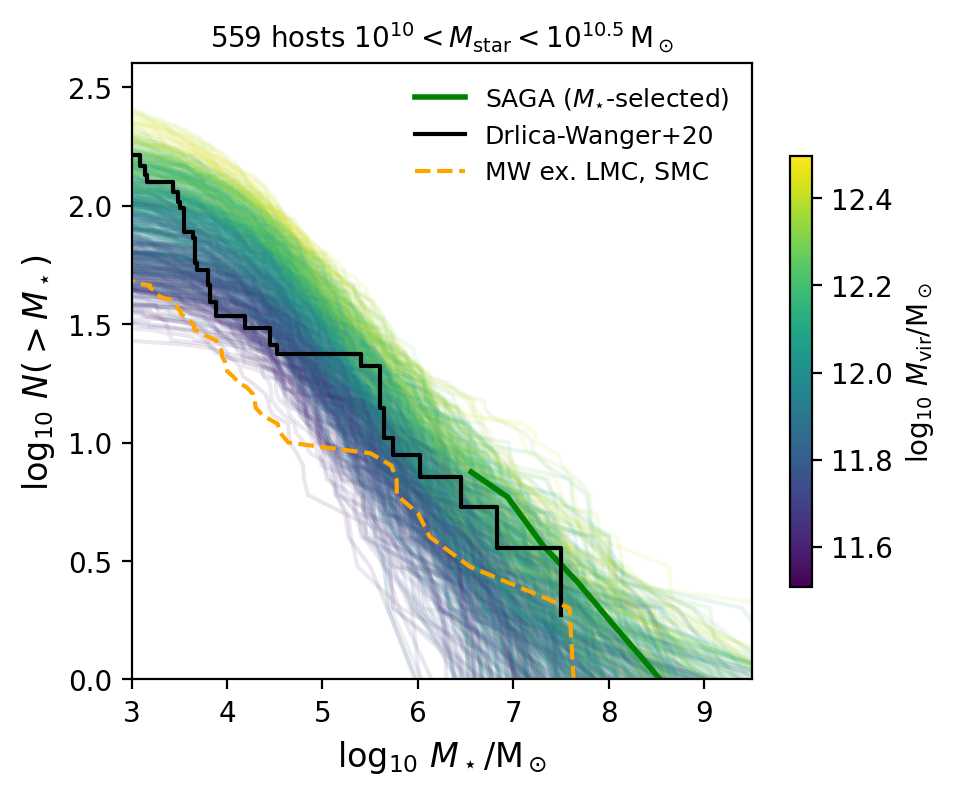

In [285]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Select MW by mstar

R_LIMIT = 200.0 # kpc

lvd_pace = '/data/apcooper/sfw/local_volume_database/data/dwarf_mw.csv'
mw_sats  = Table.read(lvd_pace)
mw_sats_mstar = mw_sats['mass_stellar'].data

mw_sats_rgc   = mw_sats['distance_host']
mw_sats_mstar = mw_sats_mstar[mw_sats_rgc < R_LIMIT]

lvd_pace = '/data/apcooper/sfw/local_volume_database/data/dwarf_m31.csv'
m31_sats  = Table.read(lvd_pace)
m31_sats_mstar = m31_sats['mass_stellar'].data

pl.figure(figsize=(5,4))
ax1 = pl.subplot(1,1,1)

# Select super-MW-like halo mass
s = mw_by_mstar_all_in
itrees_mw = np.flatnonzero(s)
    
norm = mcolors.Normalize(vmin=min(np.log10(root_mass[s])), vmax=max(np.log10(root_mass[s])))
cmap = cm.viridis  # or any other colormap

# Plot one example
for itree in itrees_mw:
    
    this_tree = np.flatnonzero(tree_idx == itree)
    
    mstar_fin_all = final_mstar[this_tree]
    mstar_ini_all = initial_mstar[this_tree]
    mass_fin_all  = final_mass[this_tree]
    mass_ini_all  = initial_mass[this_tree]
    
    r_fin_all     = final_radius[this_tree]

    f_star_bound = mstar_fin_all/mstar_ini_all
    f_mass_bound = mass_fin_all/mass_ini_all
    
    survives     = (mass_fin_all > cfg.Mres) & (f_mass_bound > cfg.psi_res)

    is_in_rvir   = r_fin_all < R_LIMIT
    
    mstar_surv = mstar_fin_all[survives]
    mstar_disr = mstar_ini_all[~survives]
    
    # Only count surviving satellites within 200kpc
    mstar_surv_rvir = mstar_fin_all[survives & is_in_rvir]
    
    # Using original mass rather than present mass and within 200kpc
    mstar_surv_orig = mstar_ini_all[survives & is_in_rvir]
    
    #### PLOT Cumulative mass functions
    
    pl.sca(ax1)
      
    # - Surviving mass, within rvir
    x  = mstar_surv_rvir
    nx = len(x)
    x_sort = np.argsort(x)
    c = cmap(norm(np.log10(root_mass[itree])))
    _p = pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),c=c,alpha=0.1)

plot_saga_cmf(pl.gca(),label='SAGA ($M_{\star}$-selected)')
#plot_koposov_cmf(pl.gca())
plot_dw_2020_cmf(pl.gca(),label='Drlica-Wanger+20')    
    
x  = 10**mw_sats_mstar
nx = len(x)
x_sort = np.argsort(x)
pl.plot(np.log10(x[x_sort][:-2]),np.log10(np.arange(nx-2,0,-1)),ls='--',c='orange',alpha=1,label='MW ex. LMC, SMC')

ax = pl.gca()
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
pl.colorbar(sm,ax=ax,shrink=0.7,label='$\log_{10}\,M_\mathrm{vir}/\mathrm{{M_\odot}}$')

pl.xlim(3,9.5)
pl.ylim(0,2.6)
pl.xlabel('$\log_{10}\,M_\star/\mathrm{M_\odot}$',fontsize=12)
pl.ylabel('$\log_{10}\,N(>M_\star)$',fontsize=12)
pl.title('{:d} hosts $10^{{10}} < M_\mathrm{{star}}<10^{{10.5}}\,\mathrm{{M_\odot}}$'.format(len(itrees_mw)),fontsize=10);
pl.legend(frameon=False,fontsize=9)


path = './figs/satellite_lf_mstar_sel_mws_with_obs_mw_set.png'
pl.savefig(path,bbox_inches='tight',pad_inches=0.1,dpi=300)

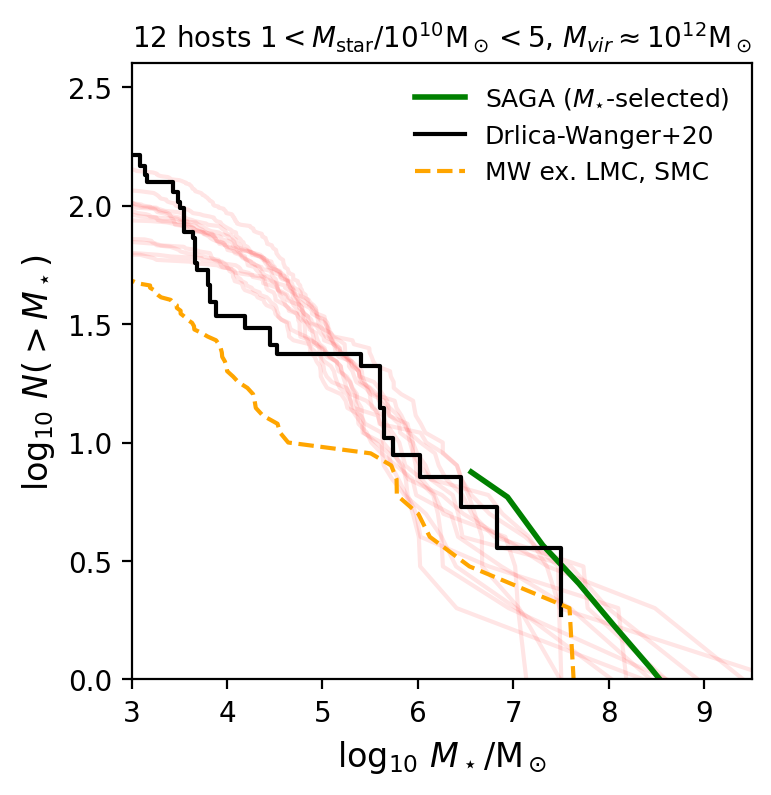

In [286]:
# Select MW by mstar and mvir
# This one doesn't add much

R_LIMIT = 200.0 # kpc

lvd_pace = '/data/apcooper/sfw/local_volume_database/data/dwarf_mw.csv'
mw_sats  = Table.read(lvd_pace)
mw_sats_mstar = mw_sats['mass_stellar'].data

mw_sats_rgc   = mw_sats['distance_host']
mw_sats_mstar = mw_sats_mstar[mw_sats_rgc < R_LIMIT]

lvd_pace = '/data/apcooper/sfw/local_volume_database/data/dwarf_m31.csv'
m31_sats  = Table.read(lvd_pace)
m31_sats_mstar = m31_sats['mass_stellar'].data

pl.figure(figsize=(4,4))
ax1 = pl.subplot(1,1,1)

# Select super-MW-like halo mass
s = (mw_by_mstar_all_in) & (np.log10(root_mass) > 11.99) & (np.log10(root_mass) < 12.01)
itrees_mw = np.flatnonzero(s)
    
# Plot one example
for itree in itrees_mw:
    
    this_tree = np.flatnonzero(tree_idx == itree)
    
    mstar_fin_all = final_mstar[this_tree]
    mstar_ini_all = initial_mstar[this_tree]
    mass_fin_all  = final_mass[this_tree]
    mass_ini_all  = initial_mass[this_tree]
    
    r_fin_all     = final_radius[this_tree]

    f_star_bound = mstar_fin_all/mstar_ini_all
    f_mass_bound = mass_fin_all/mass_ini_all
    
    survives     = (mass_fin_all > cfg.Mres) & (f_mass_bound > cfg.psi_res)

    is_in_rvir   = r_fin_all < R_LIMIT
    
    mstar_surv = mstar_fin_all[survives]
    mstar_disr = mstar_ini_all[~survives]
    
    # Only count surviving satellites within 200kpc
    mstar_surv_rvir = mstar_fin_all[survives & is_in_rvir]
    
    # Using original mass rather than present mass and within 200kpc
    mstar_surv_orig = mstar_ini_all[survives & is_in_rvir]
    
    #### PLOT Cumulative mass functions
    
    pl.sca(ax1)
      
    # - Surviving mass, within rvir
    x  = mstar_surv_rvir
    nx = len(x)
    x_sort = np.argsort(x)
    _p = pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),c='r',alpha=0.1)

plot_saga_cmf(pl.gca(),label='SAGA ($M_{\star}$-selected)')
#plot_koposov_cmf(pl.gca())
plot_dw_2020_cmf(pl.gca(),label='Drlica-Wanger+20')    
    
x  = 10**mw_sats_mstar
nx = len(x)
x_sort = np.argsort(x)
pl.plot(np.log10(x[x_sort][:-2]),np.log10(np.arange(nx-2,0,-1)),ls='--',c='orange',alpha=1,label='MW ex. LMC, SMC')

    
pl.xlim(3,9.5)
pl.ylim(0,2.6)
pl.xlabel('$\log_{10}\,M_\star/\mathrm{M_\odot}$',fontsize=12)
pl.ylabel('$\log_{10}\,N(>M_\star)$',fontsize=12)

pl.title('{:d} hosts $1 < M_\mathrm{{star}}/10^{{10}}\mathrm{{M_\odot}} < 5$, $M_{{vir}} \\approx 10^{{12}}\mathrm{{M_\odot}}$'.format(len(itrees_mw)),fontsize=10);
pl.legend(frameon=False,fontsize=9)

path = './figs/satellite_lf_mstar_and_mvir_sel_mws_with_obs_mw_set.png'
pl.savefig(path,bbox_inches='tight',pad_inches=0.1,dpi=300)

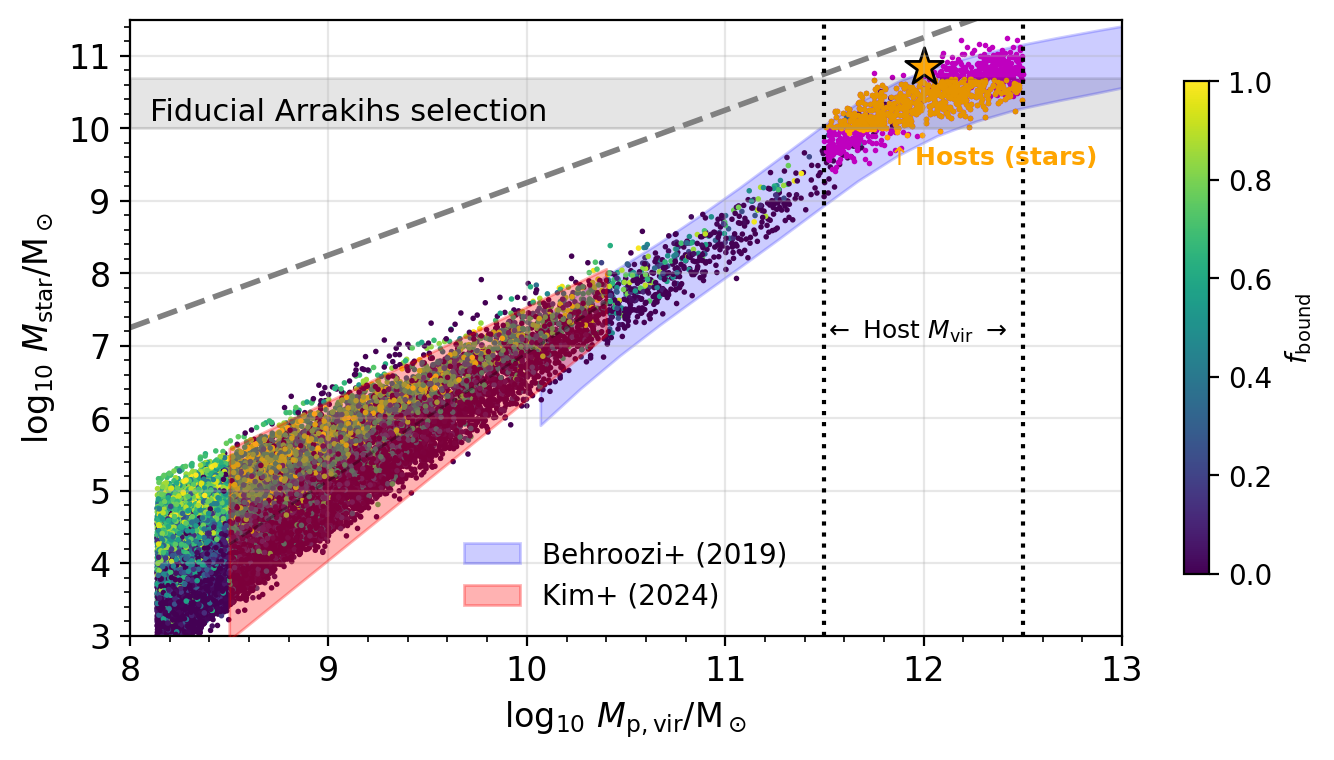

In [221]:
pl.figure(figsize=(8,4))

f_star_bound = final_mstar/initial_mstar
f_mass_bound = final_mass/initial_mass

survives     = (final_mass > cfg.Mres) & (f_mass_bound > cfg.psi_res)
    
r = np.argsort(np.random.random(len(initial_mass)))[0:30000]

pl.scatter(np.log10(initial_mass[r]), np.log10(initial_mstar[r]), 
           c=f_mass_bound[r], vmin=0, vmax=1, s=1)
pl.colorbar(shrink=0.8,label='$f_\mathrm{bound}$')

#pl.scatter(np.log10(initial_mass[~survives]), np.log10(initial_mstar[~survives]), 
#           edgecolor='r', marker='o', facecolor='None')

pl.scatter(np.log10(root_mass), np.log10(mstar_main_all), 
           c='m', vmin=0, vmax=1, s=1)

s = mw_by_mstar_all_in
pl.scatter(np.log10(root_mass[s]), np.log10(mstar_main_all[s]), 
           c='orange', vmin=0, vmax=1, s=1)

# It seems this doesn't make much difference in narrowing down to
# the left side of the SMHM relation.

#s = (tree_late_tot_prog_mass_frac < 0.05)# & mw_by_mstar_all_in
#pl.scatter(np.log10(root_mass[s]), np.log10(mstar_main_all[s]), 
#           c='lime', vmin=0, vmax=1, s=1)


OMEGA_B = 0.04455
OMEGA_0 = 0.25
baryon_mass_fraction = OMEGA_B/OMEGA_0 
xx = np.arange(8,14,0.1)
yy = xx+np.log10(baryon_mass_fraction)
pl.plot(xx,yy,c='grey',lw=2,ls='--')

ax = pl.gca()
plot_b18(ax,c='b',h=0.73)
#plot_m18(ax,c='g',h=0.73)

# Kim et al 2024 / Darklight
# xx is log M200
xx = np.arange(8.5,10.5,0.1)
yy_kim_mean = 1.76*xx - 10.7
kim_sigma = -0.227*xx + 2.59
pl.plot(xx, yy_kim_mean, c='k',lw=1,ls='--',alpha=0.3,zorder=100)
#pl.plot(xx, yy_kim_mean-2*kim_sigma, c='yellow',zorder=20,lw=1,ls='--')
#pl.plot(xx, yy_kim_mean+2*kim_sigma, c='yellow',zorder=20,lw=1,ls='--')
pl.fill_between(xx,
                yy_kim_mean-2*kim_sigma,
                yy_kim_mean+2*kim_sigma,color='r',alpha=0.3,
                label='Kim+ (2024)',zorder=20)
    
pl.scatter([12],[np.log10(7e10)],c='orange', marker='*', edgecolor='k', s=200)
pl.fill_between(np.arange(8,15,0.1),10,np.log10(5e10),color='k',alpha=0.1)
pl.ylabel('$\log_{10}\,M_\mathrm{star}/\mathrm{M_\odot}$',fontsize=12)
pl.xlabel('$\log_{10}\,M_\mathrm{p,vir}/\mathrm{M_\odot}$',fontsize=12)

pl.text(8.1,10.1,'Fiducial Arrakihs selection',fontsize=11)
pl.text(11.5,7.1,'$\leftarrow$ Host $M_\mathrm{vir}$ $\\rightarrow$',fontsize=9)

pl.text(11.8,9.5,'$\\uparrow$Hosts (stars)',fontdict={'weight':'bold'},color='orange',fontsize=9)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.minorticks_on()
pl.grid(alpha=0.3)
pl.legend(frameon=False)
pl.axvline(11.5,ls=':',c='k')
pl.axvline(12.5,ls=':',c='k')
pl.ylim(3,11.5)
pl.xlim(8,13);

path = './figs/sample_progenitors_logmass_range_set.png'
pl.savefig(path,bbox_inches='tight',pad_inches=0.1,dpi=300)

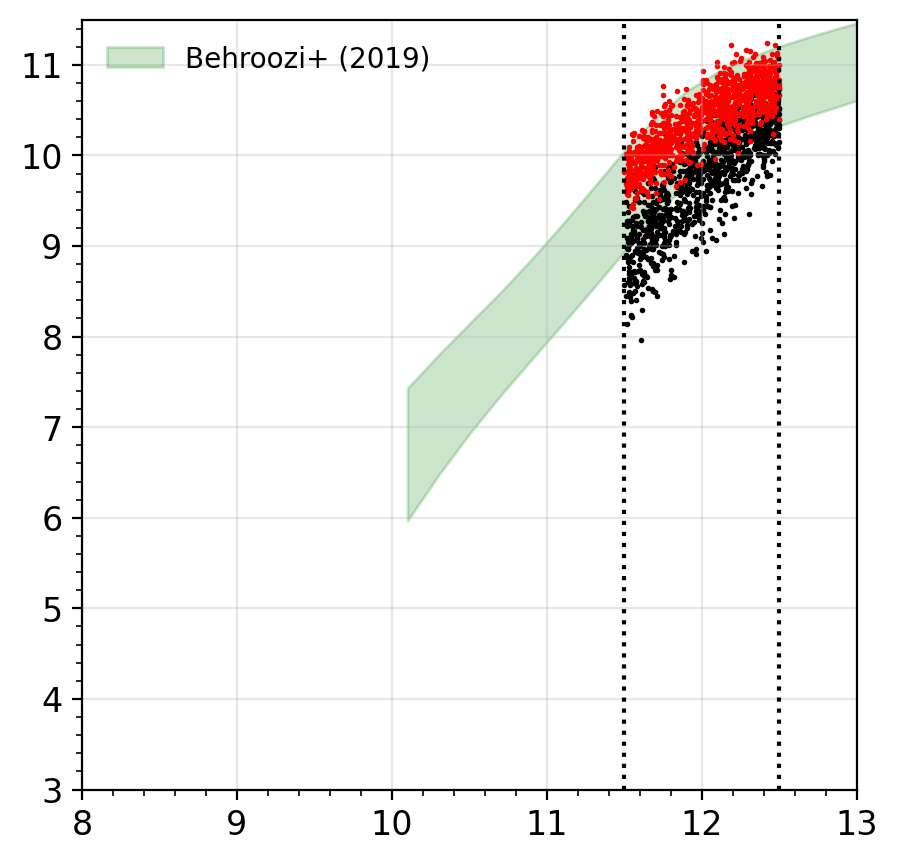

In [222]:
pl.figure(figsize=(5,5))
ax = pl.gca()

f_star_bound = final_mstar/initial_mstar
f_mass_bound = final_mass/initial_mass

survives     = (final_mass > cfg.Mres) & (f_mass_bound > cfg.psi_res)
    
pl.scatter(np.log10(root_mass),np.log10(mstar_main_smooth),c='k',s=1)
pl.scatter(np.log10(root_mass),np.log10(mstar_main_all),c='r',s=1)

plot_b18(ax)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.minorticks_on()
pl.grid(alpha=0.3)
pl.legend(frameon=False)
pl.axvline(11.5,ls=':',c='k')
pl.axvline(12.5,ls=':',c='k')
pl.ylim(3,11.5)
pl.xlim(8,13);

In [223]:
# https://gitlab.cefca.es/arrakihs/sci/sur/gitlab-profile/-/wikis/SUR-SAM:-Sample-selection

In [224]:
# Rule out those with massive satellites
# Count stream mass

In [225]:
!h5ls ./satgen_pchtrees/output_satgen_1000_mixed.hdf5/Progenitors

HostMass                 Dataset {472915/Inf}
MergedMass               Dataset {472915/Inf}
MergedZred               Dataset {472915/Inf}
ProgenitorMass           Dataset {472915/Inf}
ProgenitorZred           Dataset {472915/Inf}
TreeID                   Dataset {472915/Inf}


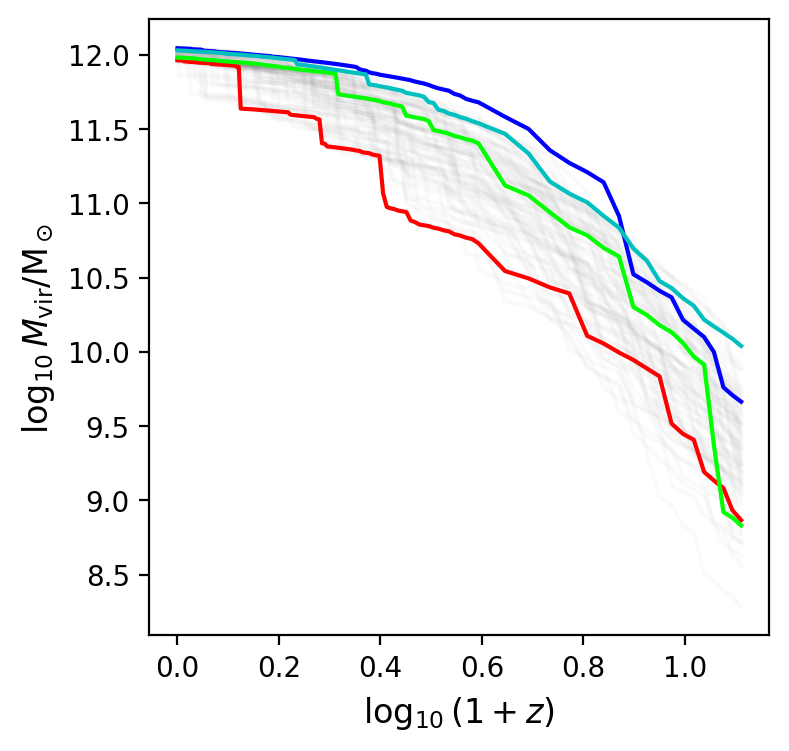

In [226]:
pl.figure(figsize=(4,4))

tree_lbk = cosmology.lookback_time(tree_redshifts).value

s = mw_by_mstar_all_in & (np.log10(root_mass) > 11.95) & (np.log10(root_mass) < 12.05)
def plot_one_history(itree,c='k',alpha=1):
    valid = tree_main_branch_masses[s][itree] > 0
    pl.plot(np.log10(1+tree_redshifts[valid]),
    np.log10(tree_main_branch_masses[s][itree][valid]),alpha=alpha,c=c)

for itree in range(int(s.sum())):
    valid = tree_main_branch_masses[s][itree] > 0
    pl.plot(np.log10(1+tree_redshifts[valid]),
            np.log10(tree_main_branch_masses[s][itree][valid]),alpha=0.02,c='k')

select_itree = np.argmin(tree_main_branch_masses[s][:,100])
plot_one_history(select_itree,'r')

select_itree = np.argmax(tree_main_branch_masses[s][:,100])
plot_one_history(select_itree,'b')

select_itree = 6
plot_one_history(select_itree,'lime')

select_itree = np.argmax(tree_main_branch_masses[s][:,-1])
plot_one_history(select_itree,'c')

pl.xlabel('$\log_{10} (1+z)$',fontsize=12)
pl.ylabel('$\log_{10} M_\mathrm{vir}/\mathrm{M_\odot}$',fontsize=12)

path = './figs/growth_histories_logmass_range_set_mw_by_mstar_and_mvir.png'
pl.savefig(path,bbox_inches='tight',pad_inches=0.1,dpi=300)

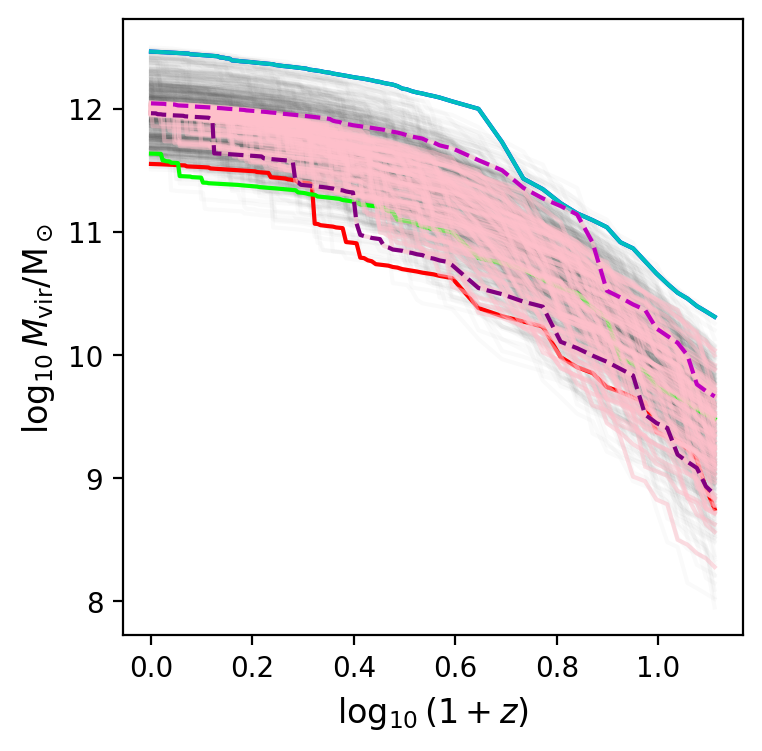

In [227]:
pl.figure(figsize=(4,4))

tree_lbk = cosmology.lookback_time(tree_redshifts).value

# Restrict mstar only

s = mw_by_mstar_all_in
def plot_one_history(itree,c='k',alpha=1,ls='solid'):
    valid = tree_main_branch_masses[s][itree] > 0
    pl.plot(np.log10(1+tree_redshifts[valid]),
    np.log10(tree_main_branch_masses[s][itree][valid]),alpha=alpha,c=c,ls=ls)

for itree in range(int(s.sum())):
    valid = tree_main_branch_masses[s][itree] > 0
    pl.plot(np.log10(1+tree_redshifts[valid]),
            np.log10(tree_main_branch_masses[s][itree][valid]),alpha=0.02,c='k')

select_itree = np.argmin(tree_main_branch_masses[s][:,100])
plot_one_history(select_itree,'r')

select_itree = np.argmax(tree_main_branch_masses[s][:,100])
plot_one_history(select_itree,'b')

select_itree = 6
plot_one_history(select_itree,'lime')

select_itree = np.argmax(tree_main_branch_masses[s][:,-1])
plot_one_history(select_itree,'c')

# Restrict mvir and mstar

s = mw_by_mstar_all_in & (np.log10(root_mass) > 11.95) & (np.log10(root_mass) < 12.05)
def plot_one_history(itree,c='k',alpha=1,ls='solid'):
    valid = tree_main_branch_masses[s][itree] > 0
    pl.plot(np.log10(1+tree_redshifts[valid]),
    np.log10(tree_main_branch_masses[s][itree][valid]),alpha=alpha,c=c,ls=ls)

for itree in range(int(s.sum())):
    valid = tree_main_branch_masses[s][itree] > 0
    pl.plot(np.log10(1+tree_redshifts[valid]),
            np.log10(tree_main_branch_masses[s][itree][valid]),alpha=0.5,c='pink')

select_itree = np.argmin(tree_main_branch_masses[s][:,100])
plot_one_history(select_itree,'purple',ls='--')

select_itree = np.argmax(tree_main_branch_masses[s][:,100])
plot_one_history(select_itree,'m',ls='--')

pl.xlabel('$\log_{10} (1+z)$',fontsize=12)
pl.ylabel('$\log_{10} M_\mathrm{vir}/\mathrm{M_\odot}$',fontsize=12)

path = './figs/growth_histories_logmass_range_set_mw_by_mstar_and_mvir_all.png'
pl.savefig(path,bbox_inches='tight',pad_inches=0.1,dpi=300)

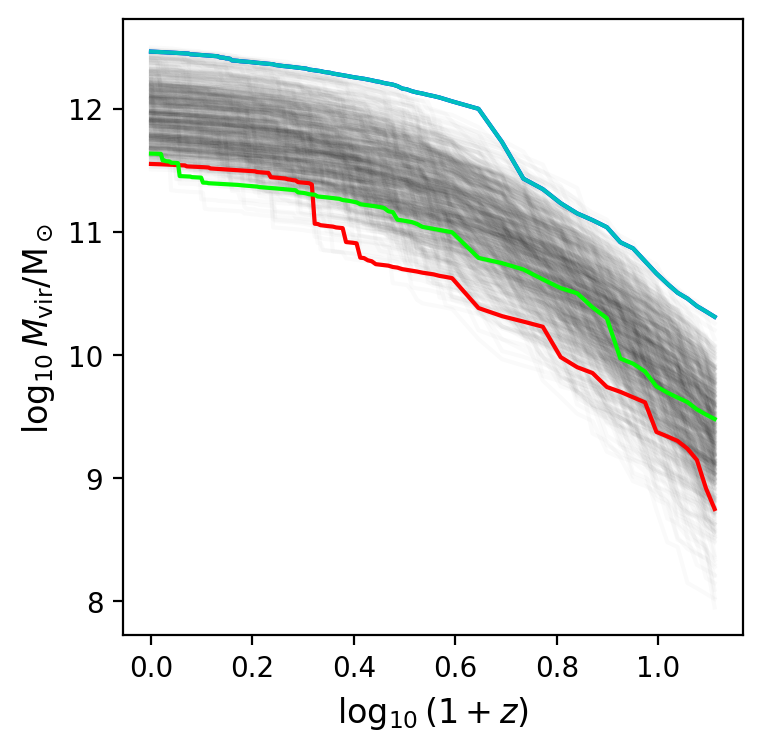

In [228]:
pl.figure(figsize=(4,4))

tree_lbk = cosmology.lookback_time(tree_redshifts).value

# Restrict mstar only

s = mw_by_mstar_all_in
def plot_one_history(itree,c='k',alpha=1,ls='solid'):
    valid = tree_main_branch_masses[s][itree] > 0
    pl.plot(np.log10(1+tree_redshifts[valid]),
    np.log10(tree_main_branch_masses[s][itree][valid]),alpha=alpha,c=c,ls=ls)

for itree in range(int(s.sum())):
    valid = tree_main_branch_masses[s][itree] > 0
    pl.plot(np.log10(1+tree_redshifts[valid]),
            np.log10(tree_main_branch_masses[s][itree][valid]),alpha=0.02,c='k')

select_itree = np.argmin(tree_main_branch_masses[s][:,100])
plot_one_history(select_itree,'r')

select_itree = np.argmax(tree_main_branch_masses[s][:,100])
plot_one_history(select_itree,'b')

select_itree = 6
plot_one_history(select_itree,'lime')

select_itree = np.argmax(tree_main_branch_masses[s][:,-1])
plot_one_history(select_itree,'c')

pl.xlabel('$\log_{10} (1+z)$',fontsize=12)
pl.ylabel('$\log_{10} M_\mathrm{vir}/\mathrm{M_\odot}$',fontsize=12)

path = './figs/growth_histories_logmass_range_set_mw_by_mstar_only.png'
pl.savefig(path,bbox_inches='tight',pad_inches=0.1,dpi=300)

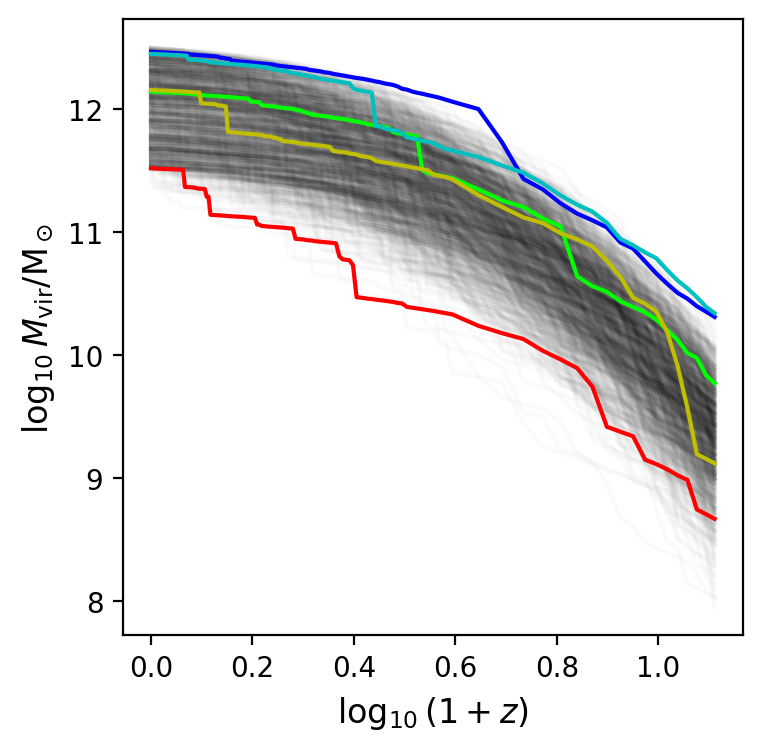

In [229]:
pl.figure(figsize=(4,4))

tree_lbk = cosmology.lookback_time(tree_redshifts).value

def plot_one_history(itree,c='k',alpha=1):
    valid = tree_main_branch_masses[itree] > 0
    pl.plot(np.log10(1+tree_redshifts[valid]),
    np.log10(tree_main_branch_masses[itree][valid]),alpha=alpha,c=c)

for itree in range(ntrees):
    valid = tree_main_branch_masses[itree] > 0
    pl.plot(np.log10(1+tree_redshifts[valid]),
            np.log10(tree_main_branch_masses[itree][valid]),alpha=0.02,c='k')

select_itree = np.argmin(tree_main_branch_masses[:,100])
plot_one_history(select_itree,'r')

select_itree = np.argmax(tree_main_branch_masses[:,100])
plot_one_history(select_itree,'b')

select_itree = 660
plot_one_history(select_itree,'lime')

select_itree = 661
plot_one_history(select_itree,'y')

select_itree = np.argmax(tree_main_branch_masses[:,-1])
plot_one_history(select_itree,'c')

pl.xlabel('$\log_{10} (1+z)$',fontsize=12)
pl.ylabel('$\log_{10} M_\mathrm{vir}/\mathrm{M_\odot}$',fontsize=12)

path = './figs/growth_histories_logmass_range_set.png'
pl.savefig(path,bbox_inches='tight',pad_inches=0.1,dpi=300)

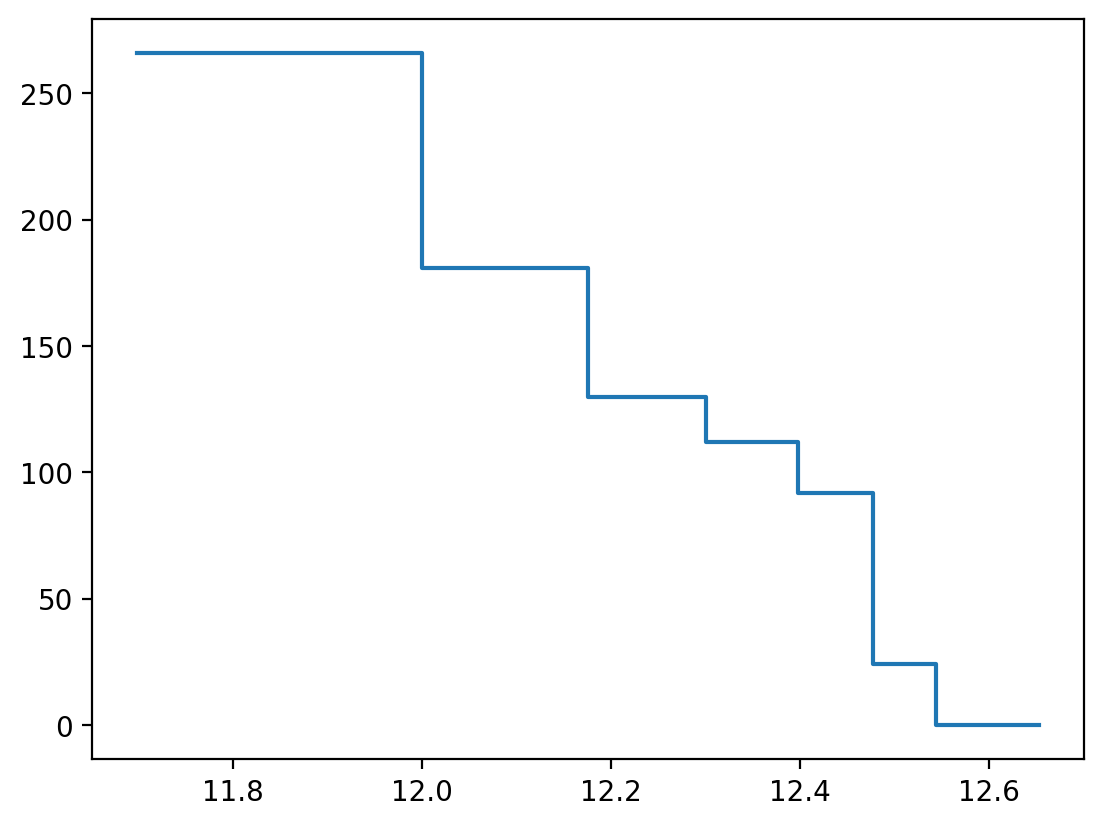

In [230]:
root_mass_bins=np.linspace(5e11,5e12,10)

h,b = np.histogram(root_mass, bins=root_mass_bins)
pl.plot(np.log10(b[:-1]),h,drawstyle='steps-post')

In [231]:
# Find the mass fraction of the z=0 halo in the most massive progenitor
tree_max_prog_mass = np.zeros(ntrees)
tree_tot_prog_mass = np.zeros(ntrees)

for itree in range(0,ntrees):
    this_tree = tree_idx == itree
    imax = np.argmax(initial_mass[this_tree])
    tree_max_prog_mass[itree] = initial_mass[this_tree][imax]
    tree_tot_prog_mass[itree] = np.sum(initial_mass[this_tree],dtype=np.float64)
tree_max_prog_mass_frac = tree_max_prog_mass/root_mass
tree_tot_prog_mass_frac = tree_tot_prog_mass/root_mass

In [232]:
# Find the mass fraction of the z=0 halo in progenitors that arrive after z=0.5
tree_late_max_prog_mass = np.zeros(ntrees)
tree_late_tot_prog_mass = np.zeros(ntrees)

for itree in range(0,ntrees):
    this_tree = (progenitors['TreeID'] == itree) & (progenitors['ProgenitorZred'] < 0.5)
    imax = np.argmax(progenitors['ProgenitorMass'][this_tree])
    tree_late_max_prog_mass[itree] = progenitors['ProgenitorMass'][this_tree][imax]
    tree_late_tot_prog_mass[itree] = np.sum(progenitors['ProgenitorMass'][this_tree],dtype=np.float64)
tree_late_max_prog_mass_frac = tree_late_max_prog_mass/root_mass
tree_late_tot_prog_mass_frac = tree_late_tot_prog_mass/root_mass

In [239]:
# Find the mass fraction of the z=0 halo in progenitors that arrive after z=0.5 and are stripped
tree_late_merged_max_prog_mass = np.zeros(ntrees)
tree_late_merged_tot_prog_mass = np.zeros(ntrees)

f_star_bound = final_mstar/initial_mstar
f_mass_bound = final_mass/initial_mass

for itree in range(0,ntrees):
    this_tree = (progenitors['TreeID'] == itree) & (progenitors['ProgenitorZred'] < 0.5) & (f_star_bound < 0.90)
    
    if np.any(this_tree):
        imax = np.argmax(progenitors['ProgenitorMass'][this_tree])
        tree_late_merged_max_prog_mass[itree] = progenitors['ProgenitorMass'][this_tree][imax]
        tree_late_merged_tot_prog_mass[itree] = np.sum(progenitors['ProgenitorMass'][this_tree],dtype=np.float64)
    else:
        tree_late_merged_max_prog_mass[itree] = 0
        tree_late_merged_tot_prog_mass[itree] = 0
        
tree_late_merged_max_prog_mass_frac = tree_late_merged_max_prog_mass/root_mass
tree_late_merged_tot_prog_mass_frac = tree_late_merged_tot_prog_mass/root_mass

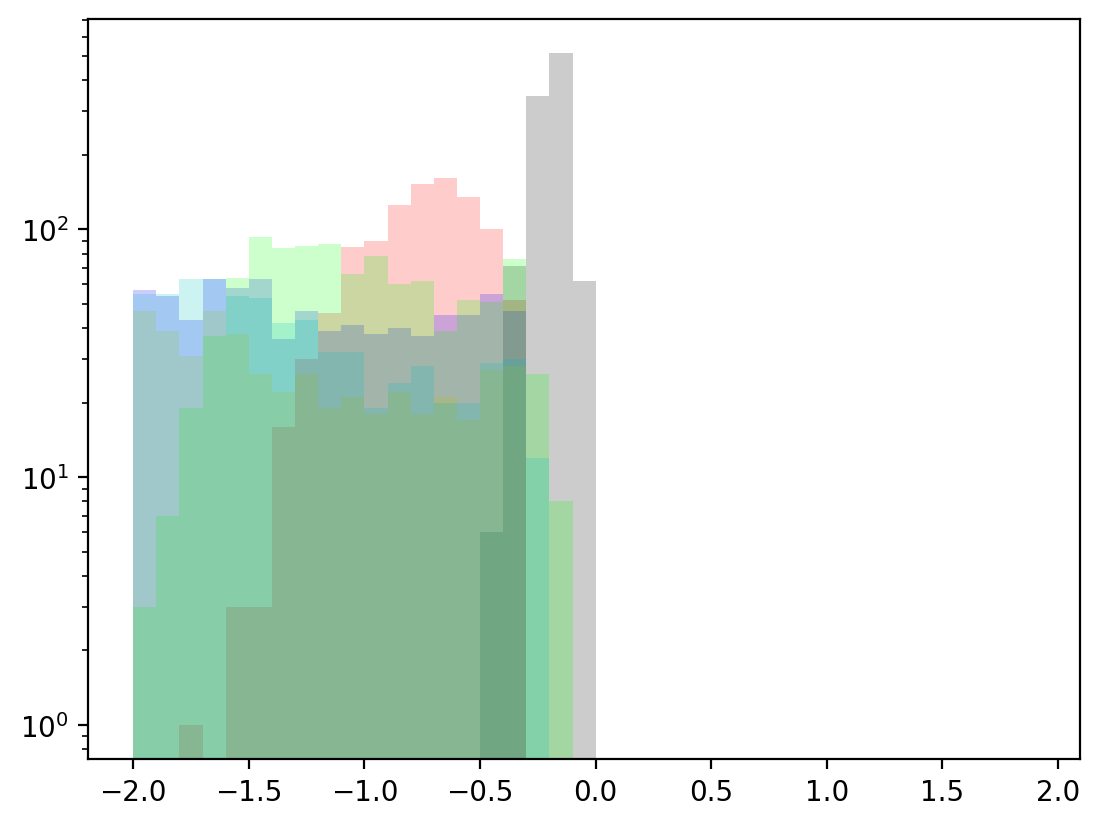

In [240]:
pl.hist(np.log10(tree_max_prog_mass_frac),bins=np.arange(-2,2,0.1),log=True,alpha=0.2,color='r',
       label='Most massive prog.');
pl.hist(np.log10(tree_tot_prog_mass_frac),bins=np.arange(-2,2,0.1),log=True,alpha=0.2,color='k',
       label='Total prog. mass frac.');

pl.hist(np.log10(tree_late_max_prog_mass_frac),bins=np.arange(-2,2,0.1),log=True,alpha=0.2,color='b',
       label='Most massive prog.');
pl.hist(np.log10(tree_late_tot_prog_mass_frac),bins=np.arange(-2,2,0.1),log=True,alpha=0.2,color='lime',
       label='Total prog. mass frac.');


pl.hist(np.log10(tree_late_merged_max_prog_mass_frac),bins=np.arange(-2,2,0.1),log=True,alpha=0.2,color='y',
       label='Most massive prog.');
pl.hist(np.log10(tree_late_merged_tot_prog_mass_frac),bins=np.arange(-2,2,0.1),log=True,alpha=0.2,color='c',
       label='Total prog. mass frac.');

In [241]:
np.sum((root_mass > 5e11) & (root_mass < 1e12))

266

In [242]:
np.sum((root_mass > 1e12) & (root_mass < 5e12))

539

In [243]:
import hmf
from hmf import MassFunction     # The main hmf class

In [244]:
mf = MassFunction()

In [245]:
OMEGA_B

0.04455

In [246]:
# Define mass bins (working in h^-1 Msol)
logM = np.log10(root_mass*hubble_parameter)
mass_bins = np.arange(10, 14.1, 0.0001)  # in log10(M/Msun/h)
bin_centers = 0.5 * (mass_bins[:-1] + mass_bins[1:])
bin_indices = np.digitize(logM, mass_bins) - 1

# Compute halo mass function using hmf
# Initialize hmf at z=0
cosmology = cosmo.FlatLambdaCDM(hubble_parameter*100,0.25,Ob0=OMEGA_B,Tcmb0=2.73)
mf = MassFunction(Mmin=11.0, Mmax=13.0, dlog10m=0.00001, z=0, cosmo_model=cosmology)

# Interpolate dn/dlog10M at bin centers
mass_function_vals = mf.dndlog10m  # units: (h/Mpc)^3 per dex

mass_vals  = np.log10(mf.m) # log10 masses from hmf
phi_interp = np.interp(bin_centers, mass_vals, mass_function_vals)

# Count trees per bin
N_trees_per_bin = np.bincount(bin_indices, minlength=len(mass_bins) - 1)

# Avoid division by zero
valid_bins = N_trees_per_bin > 0
weights_per_bin = np.zeros_like(bin_centers)
weights_per_bin[valid_bins] = phi_interp[valid_bins] / N_trees_per_bin[valid_bins]

# Assign a weight to each halo/tree
weights = weights_per_bin[bin_indices]

(7.0, 11.5)

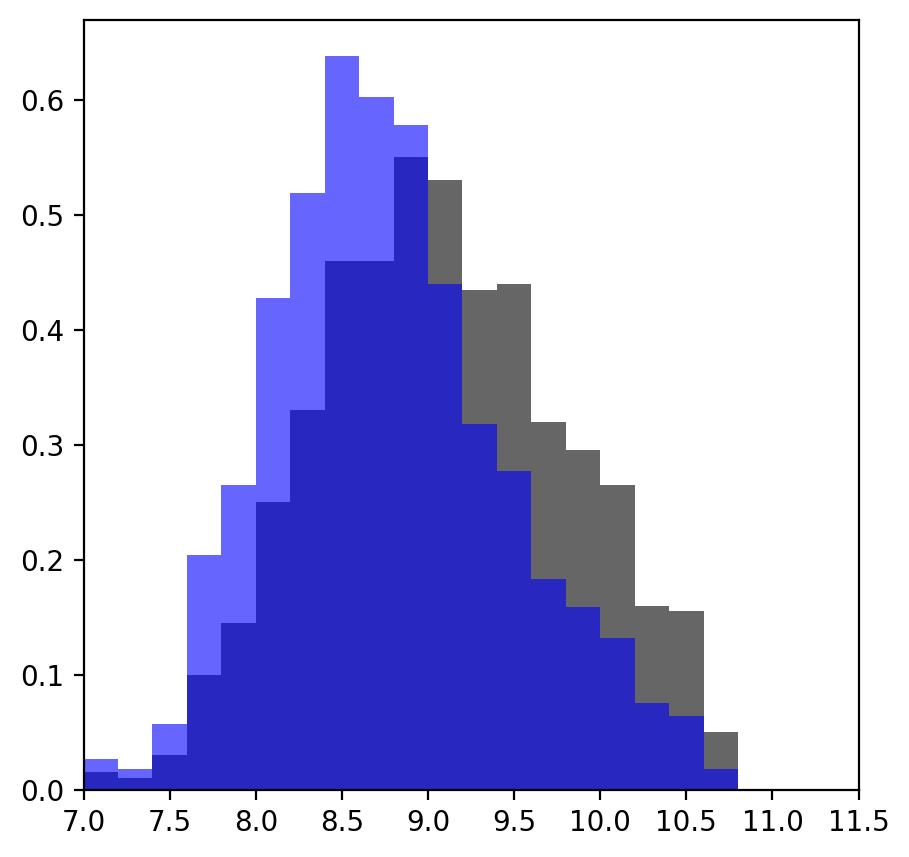

In [247]:
pl.figure(figsize=(5,5))
pl.hist(np.log10(m_acc),bins=np.arange(5,13,0.2),color='k',alpha=0.6,density=True);
pl.hist(np.log10(m_acc),bins=np.arange(5,13,0.2),weights=weights,color='b',alpha=0.6,density=True);

s = tree_max_prog_mass_frac < 0.3
#pl.hist(np.log10(m_acc[s]),
#        bins=np.arange(5,13,0.2),weights=weights[s],color='r',alpha=0.6,density=True);

pl.xlim(7,11.5)

(7.0, 11.5)

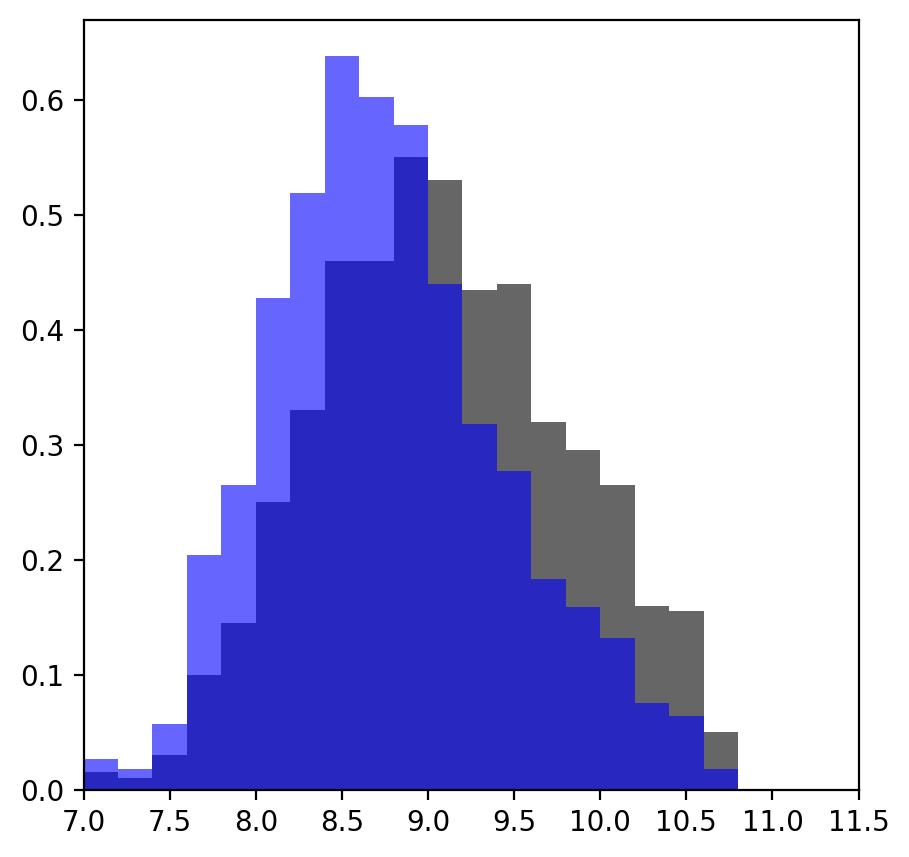

In [248]:
pl.figure(figsize=(5,5))
pl.hist(np.log10(m_acc),bins=np.arange(5,13,0.2),color='k',alpha=0.6,density=True);
pl.hist(np.log10(m_acc),bins=np.arange(5,13,0.2),weights=weights,color='b',alpha=0.6,density=True);

s = tree_max_prog_mass_frac < 0.3
#pl.hist(np.log10(m_acc[s]),
#        bins=np.arange(5,13,0.2),weights=weights[s],color='r',alpha=0.6,density=True);

pl.xlim(7,11.5)

In [249]:
np.log10(root_mass.max())

12.499992

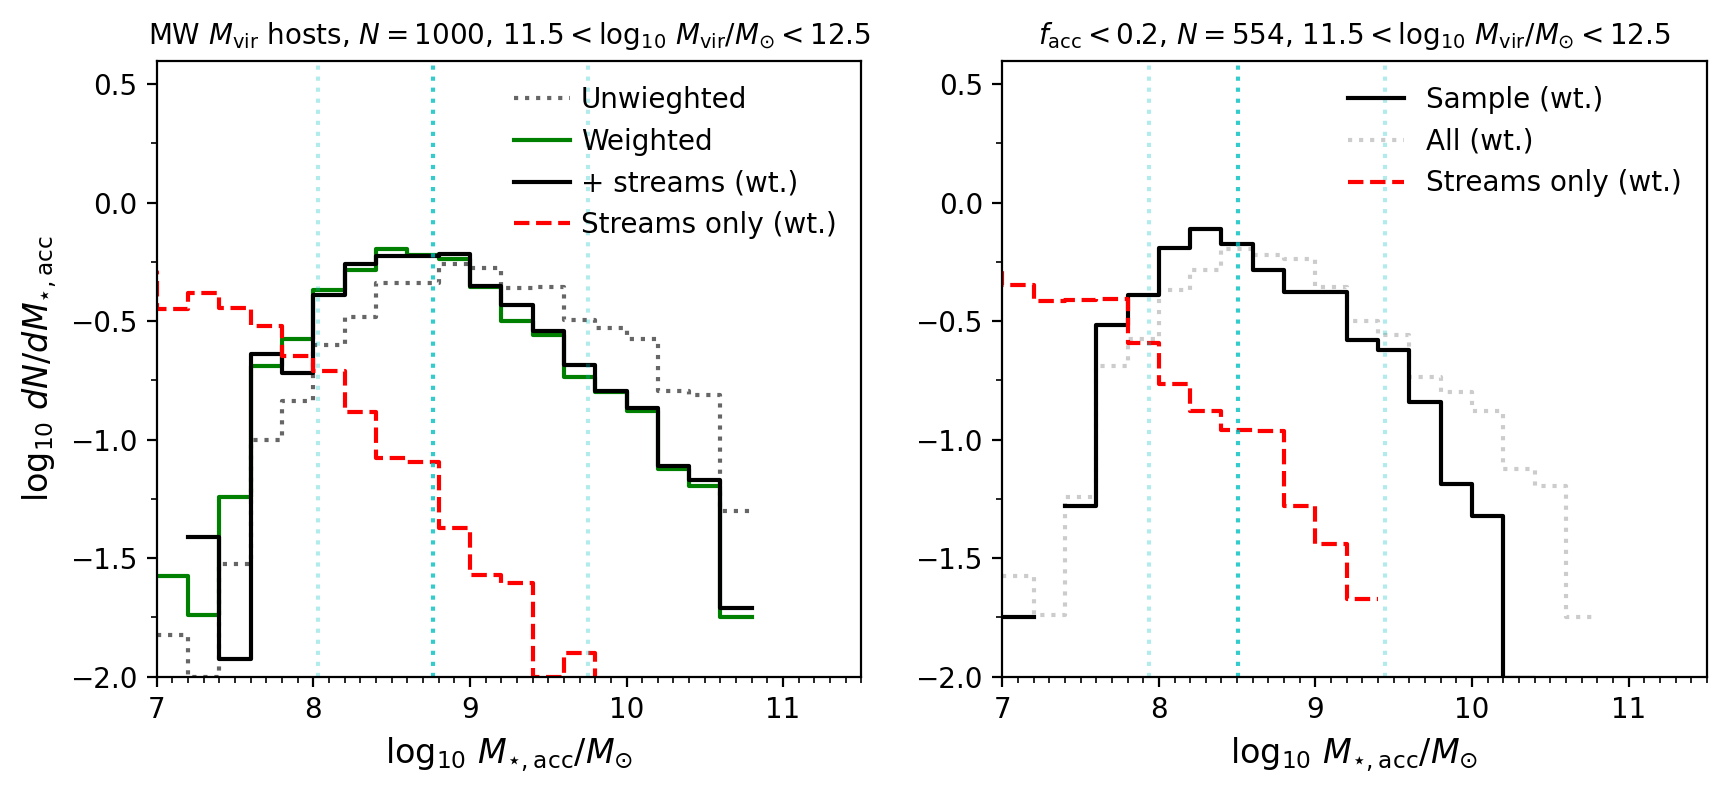

In [268]:
pl.figure(figsize=(10,4))

ax = pl.subplot(1,2,1)


h,b = np.histogram(np.log10(m_acc),bins=np.arange(5,13,0.2),density=True)
pl.plot(b[:-1],np.log10(h),color='k',alpha=0.6,drawstyle='steps-post',ls=':',label='Unwieghted');

h,b = np.histogram(np.log10(m_acc),bins=np.arange(5,13,0.2),weights=weights,density=True)
pl.plot(b[:-1],np.log10(h),color='g',alpha=1,drawstyle='steps-post',label='Weighted');

h,b = np.histogram(np.log10(m_acc+m_streams),bins=np.arange(5,13,0.2),weights=weights,density=True)
pl.plot(b[:-1],np.log10(h),color='k',alpha=1,drawstyle='steps-post',label='+ streams (wt.)');

h,b = np.histogram(np.log10(m_streams),bins=np.arange(5,13,0.2),weights=weights,density=True)
pl.plot(b[:-1],np.log10(h),color='r',alpha=1,drawstyle='steps-post',ls='--',label='Streams only (wt.)');

p10,p50,p90 = weighted_quantile(np.log10(m_acc+m_streams),[0.1,0.5,0.9],sample_weight=weights)
pl.axvline(p10,ls=':',c='c',alpha=0.3)
pl.axvline(p50,ls=':',c='c',alpha=0.8)
pl.axvline(p90,ls=':',c='c',alpha=0.3)

pl.xlim(7,11.5)
pl.ylim(-2,0.6)
pl.legend(frameon=False,ncols=1,fontsize=10,handletextpad=0.4)
pl.title('MW $M_\mathrm{vir}$ hosts, $N=1000$, $11.5<\log_{10}\,M_\mathrm{vir}/M_{\odot}<12.5$',fontsize=10)
small_tickmarks(ax,0.1,0.25)
pl.xlabel("$\log_{10}\,M_\mathrm{\star,acc}/M_{\odot}$",fontsize=12)
pl.ylabel("$\log_{10}\,dN/dM_\mathrm{\star,acc}$",fontsize=12)

ax = pl.subplot(1,2,2)

s = tree_max_prog_mass_frac < 0.2

h,b = np.histogram(np.log10(m_acc[s]),bins=np.arange(5,13,0.2),weights=weights[s],density=True)
pl.plot(b[:-1],np.log10(h),color='k',alpha=1,drawstyle='steps-post',label='Sample (wt.)');

h,b = np.histogram(np.log10(m_acc),bins=np.arange(5,13,0.2),weights=weights,density=True)
pl.plot(b[:-1],np.log10(h),color='k',alpha=0.2,drawstyle='steps-post',label='All (wt.)',ls=':');

h,b = np.histogram(np.log10(m_streams[s]),bins=np.arange(5,13,0.2),weights=weights[s],density=True)
pl.plot(b[:-1],np.log10(h),color='r',alpha=1,drawstyle='steps-post',ls='--',label='Streams only (wt.)');

p10,p50,p90 = weighted_quantile(np.log10(m_acc[s]+m_streams[s]),[0.1,0.5,0.9],sample_weight=weights[s])
pl.axvline(p10,ls=':',c='c',alpha=0.3)
pl.axvline(p50,ls=':',c='c',alpha=0.8)
pl.axvline(p90,ls=':',c='c',alpha=0.3)

pl.xlim(7,11.5)
pl.ylim(-2,0.6)
pl.legend(frameon=False,ncols=1,fontsize=10)
pl.title(r'$f_\mathrm{{acc}}<0.2$, $N={:d}$, $11.5<\log_{{10}}\,M_\mathrm{{vir}}/M_{{\odot}}<12.5$'.format(s.sum()),
         fontsize=10)
small_tickmarks(ax,0.1,0.25)
pl.xlabel("$\log_{10}\,M_\mathrm{\star,acc}/M_{\odot}$",fontsize=12);

path = './figs/mvir_macc_distribution_logmass_range_set_MACCALL.png'
pl.savefig(path,bbox_inches='tight',pad_inches=0.1,dpi=300)

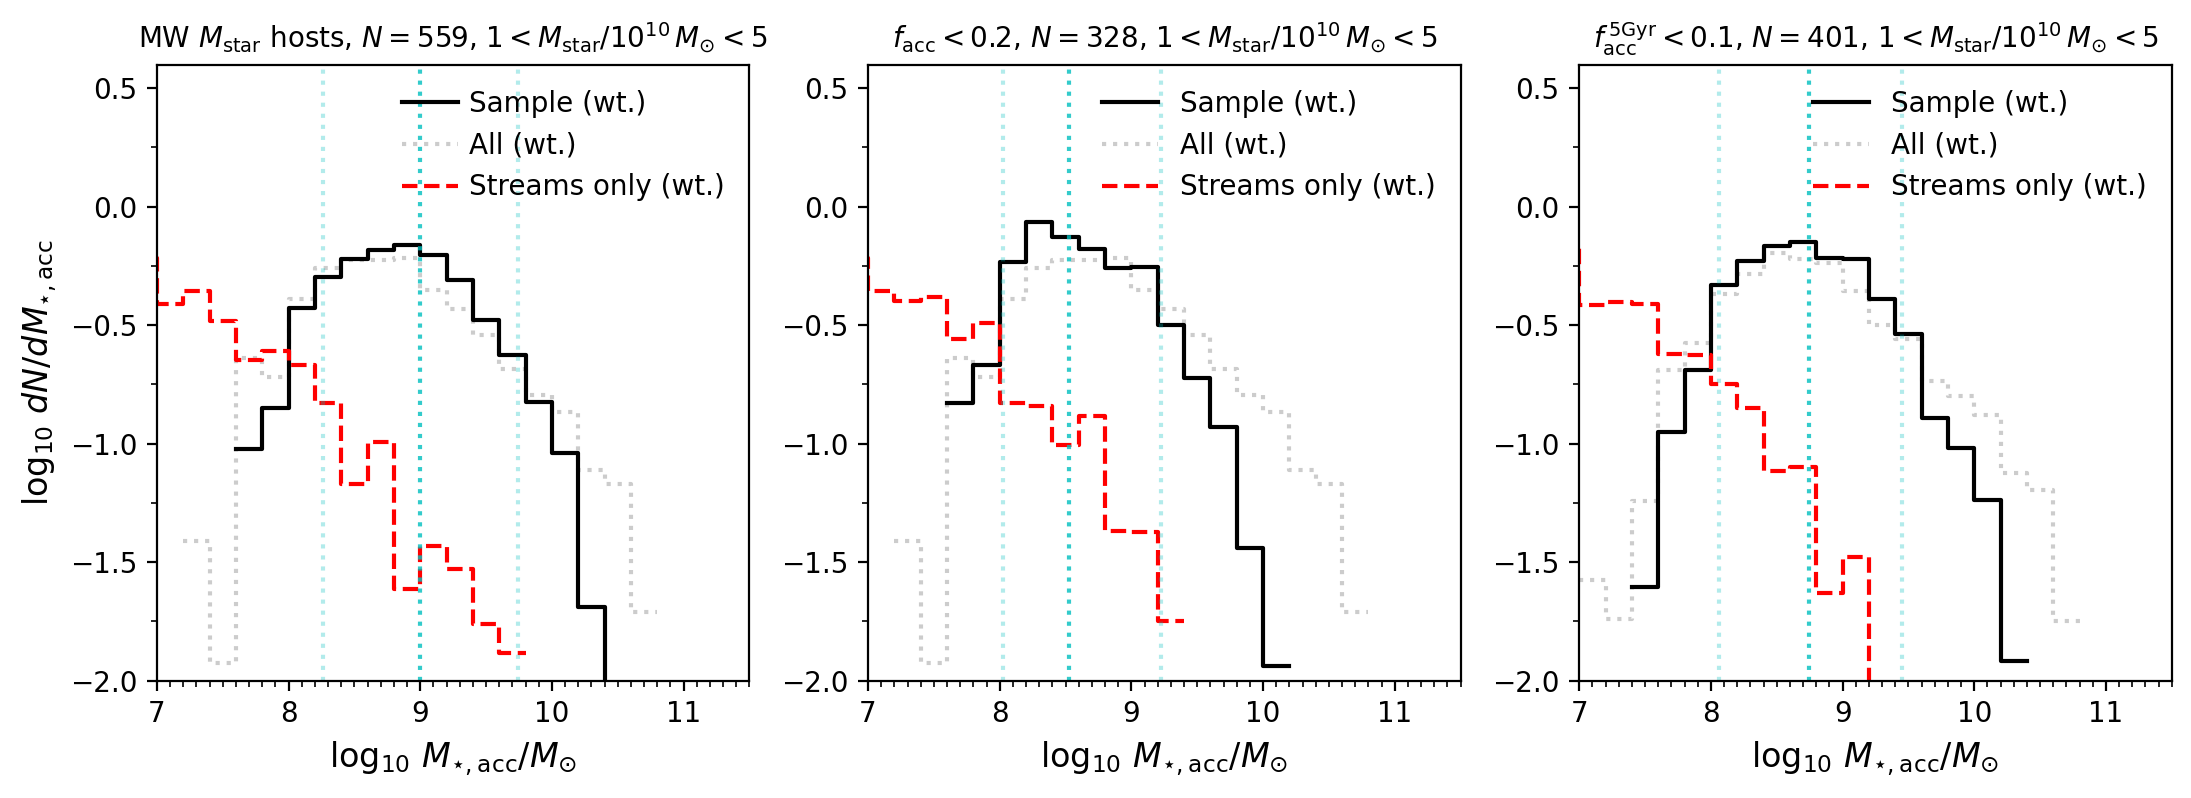

In [251]:
pl.figure(figsize=(13,4))

ax = pl.subplot(1,3,1)

s = mw_by_mstar_all_in

h,b = np.histogram(np.log10(m_acc[s]+m_streams[s]),bins=np.arange(5,13,0.2),weights=weights[s],density=True)
pl.plot(b[:-1],np.log10(h),color='k',alpha=1,drawstyle='steps-post',label='Sample (wt.)');

h,b = np.histogram(np.log10(m_acc+m_streams),bins=np.arange(5,13,0.2),weights=weights,density=True)
pl.plot(b[:-1],np.log10(h),color='k',alpha=0.2,drawstyle='steps-post',label='All (wt.)',ls=':');

h,b = np.histogram(np.log10(m_streams[s]),bins=np.arange(5,13,0.2),weights=weights[s],density=True)
pl.plot(b[:-1],np.log10(h),color='r',alpha=1,drawstyle='steps-post',ls='--',label='Streams only (wt.)');

p10,p50,p90 = weighted_quantile(np.log10(m_acc[s]),[0.1,0.5,0.9],sample_weight=weights)
pl.axvline(p10,ls=':',c='c',alpha=0.3)
pl.axvline(p50,ls=':',c='c',alpha=0.8)
pl.axvline(p90,ls=':',c='c',alpha=0.3)

pl.xlim(7,11.5)
pl.ylim(-2,0.6)
pl.legend(frameon=False,ncols=1,fontsize=10,handletextpad=0.4)
pl.title(f'MW $M_\mathrm{{star}}$ hosts, $N={s.sum():d}$, $1< M_\mathrm{{star}}/10^{{10}}\,M_{{\odot}} < 5$',
         fontsize=10)
small_tickmarks(ax,0.1,0.25)
pl.xlabel("$\log_{10}\,M_\mathrm{\star,acc}/M_{\odot}$",fontsize=12)
pl.ylabel("$\log_{10}\,dN/dM_\mathrm{\star,acc}$",fontsize=12)

ax = pl.subplot(1,3,2)

s = (tree_max_prog_mass_frac < 0.2) & mw_by_mstar_all_in

h,b = np.histogram(np.log10(m_acc[s]+m_streams[s]),bins=np.arange(5,13,0.2),weights=weights[s],density=True)
pl.plot(b[:-1],np.log10(h),color='k',alpha=1,drawstyle='steps-post',label='Sample (wt.)');

h,b = np.histogram(np.log10(m_acc+m_streams),bins=np.arange(5,13,0.2),weights=weights,density=True)
pl.plot(b[:-1],np.log10(h),color='k',alpha=0.2,drawstyle='steps-post',label='All (wt.)',ls=':');

h,b = np.histogram(np.log10(m_streams[s]),bins=np.arange(5,13,0.2),weights=weights[s],density=True)
pl.plot(b[:-1],np.log10(h),color='r',alpha=1,drawstyle='steps-post',ls='--',label='Streams only (wt.)');

p10,p50,p90 = weighted_quantile(np.log10(m_acc[s]),[0.1,0.5,0.9],sample_weight=weights[s])
pl.axvline(p10,ls=':',c='c',alpha=0.3)
pl.axvline(p50,ls=':',c='c',alpha=0.8)
pl.axvline(p90,ls=':',c='c',alpha=0.3)

pl.xlim(7,11.5)
pl.ylim(-2,0.6)
pl.legend(frameon=False,ncols=1,fontsize=10)
pl.title(r'$f_\mathrm{{acc}}<0.2$, $N={:d}$, $1 < M_\mathrm{{star}}/10^{{10}}\,M_{{\odot}}<5$'.format(s.sum()),
         fontsize=10)
small_tickmarks(ax,0.1,0.25)
pl.xlabel("$\log_{10}\,M_\mathrm{\star,acc}/M_{\odot}$",fontsize=12);

ax = pl.subplot(1,3,3)

s = (tree_late_max_prog_mass_frac < 0.1) & mw_by_mstar_all_in

h,b = np.histogram(np.log10(m_acc[s]),bins=np.arange(5,13,0.2),weights=weights[s],density=True)
pl.plot(b[:-1],np.log10(h),color='k',alpha=1,drawstyle='steps-post',label='Sample (wt.)');

h,b = np.histogram(np.log10(m_acc),bins=np.arange(5,13,0.2),weights=weights,density=True)
pl.plot(b[:-1],np.log10(h),color='k',alpha=0.2,drawstyle='steps-post',label='All (wt.)',ls=':');

h,b = np.histogram(np.log10(m_streams[s]),bins=np.arange(5,13,0.2),weights=weights[s],density=True)
pl.plot(b[:-1],np.log10(h),color='r',alpha=1,drawstyle='steps-post',ls='--',label='Streams only (wt.)');

p10,p50,p90 = weighted_quantile(np.log10(m_acc[s]),[0.1,0.5,0.9],sample_weight=weights[s])
pl.axvline(p10,ls=':',c='c',alpha=0.3)
pl.axvline(p50,ls=':',c='c',alpha=0.8)
pl.axvline(p90,ls=':',c='c',alpha=0.3)

pl.xlim(7,11.5)
pl.ylim(-2,0.6)
pl.legend(frameon=False,ncols=1,fontsize=10)
pl.title(r'$f_\mathrm{{acc}}^{{\mathrm{{\,5Gyr}}}}<0.1$, $N={:d}$, $1 < M_\mathrm{{star}}/10^{{10}}\,M_{{\odot}}<5$'.format(s.sum()),
         fontsize=10)
small_tickmarks(ax,0.1,0.25)
pl.xlabel("$\log_{10}\,M_\mathrm{\star,acc}/M_{\odot}$",fontsize=12);

path = './figs/mvir_macc_distribution_logmass_range_set_mw_by_mstar.png'
pl.savefig(path,bbox_inches='tight',pad_inches=0.1,dpi=300)

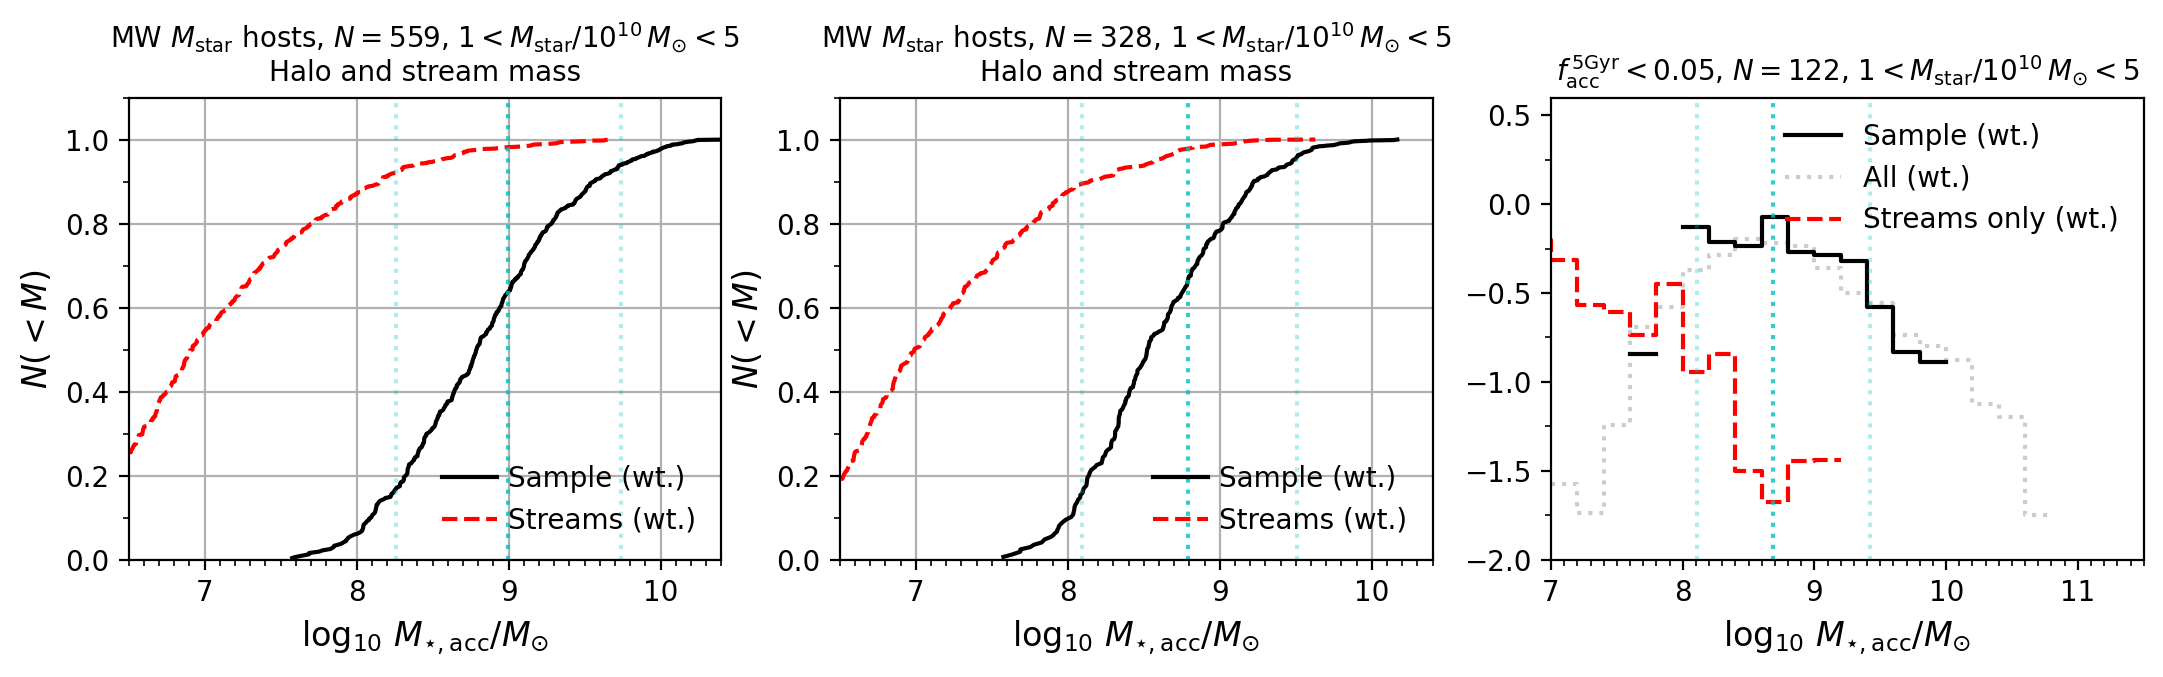

In [257]:
# Cumulative plots
# Fraction of sample having halo/stream brighter than X

pl.figure(figsize=(13,3))

ax = pl.subplot(1,3,1)

# MW sample
s = mw_by_mstar_all_in

# Cumulative halo brighter than M
g = np.argsort(m_acc[s])
pl.plot(np.log10((m_acc[s])[g]), np.cumsum(weights[s][g])/weights[s].sum(),
                 color='k',alpha=1,label='Sample (wt.)')
    
g = np.argsort(m_streams[s])
pl.plot(np.log10((m_streams[s])[g]), np.cumsum(weights[s][g])/weights[s].sum(),
                 color='r',alpha=1,ls='--',label='Streams (wt.)')
                 
p10,p50,p90 = weighted_quantile(np.log10(m_acc[s]),[0.1,0.5,0.9],sample_weight=weights)
pl.axvline(p10,ls=':',c='c',alpha=0.3)
pl.axvline(p50,ls=':',c='c',alpha=0.8)
pl.axvline(p90,ls=':',c='c',alpha=0.3)
pl.grid()

small_tickmarks(ax,0.1,0.1)

pl.xlim(6.5,10.4)
pl.ylim(0,1.1)
pl.legend(frameon=False,ncols=1,fontsize=10,handletextpad=0.4)
pl.title(f'MW $M_\mathrm{{star}}$ hosts, $N={s.sum():d}$, $1< M_\mathrm{{star}}/10^{{10}}\,M_{{\odot}} < 5$\nHalo and stream mass',
         fontsize=10)
#small_tickmarks(ax,0.1,0.25)
pl.xlabel("$\log_{10}\,M_\mathrm{\star,acc}/M_{\odot}$",fontsize=12)
pl.ylabel("$N(<M)$",fontsize=12)

ax = pl.subplot(1,3,2)

s = mw_by_mstar_all_in

# Cumulative brightest sat brighter than M
g = np.argsort(m_acc[s])
pl.plot(np.log10((m_acc[s])[g]), np.cumsum(weights[s][g])/weights[s].sum(),
                 color='k',alpha=1,label='Sample (wt.)')
    
g = np.argsort(m_streams[s])
pl.plot(np.log10((m_streams[s])[g]), np.cumsum(weights[s][g])/weights[s].sum(),
                 color='r',alpha=1,ls='--',label='Streams (wt.)')
                 
p10,p50,p90 = weighted_quantile(np.log10(m_acc[s]),[0.1,0.5,0.9],sample_weight=weights)
pl.axvline(p10,ls=':',c='c',alpha=0.3)
pl.axvline(p50,ls=':',c='c',alpha=0.8)
pl.axvline(p90,ls=':',c='c',alpha=0.3)
pl.grid()

small_tickmarks(ax,0.1,0.1)

pl.xlim(6.5,10.4)
pl.ylim(0,1.1)
pl.legend(frameon=False,ncols=1,fontsize=10,handletextpad=0.4)
pl.title(f'MW $M_\mathrm{{star}}$ hosts, $N={s.sum():d}$, $1< M_\mathrm{{star}}/10^{{10}}\,M_{{\odot}} < 5$\nBrightest satellite and stream',
         fontsize=10)
#small_tickmarks(ax,0.1,0.25)
pl.xlabel("$\log_{10}\,M_\mathrm{\star,acc}/M_{\odot}$",fontsize=12)
pl.ylabel("$N(<M)$",fontsize=12)

ax = pl.subplot(1,3,3)

s = (tree_late_max_prog_mass_frac < 0.01) & mw_by_mstar_all_in

h,b = np.histogram(np.log10(m_acc[s]),bins=np.arange(5,13,0.2),weights=weights[s],density=True)
pl.plot(b[:-1],np.log10(h),color='k',alpha=1,drawstyle='steps-post',label='Sample (wt.)');

h,b = np.histogram(np.log10(m_acc),bins=np.arange(5,13,0.2),weights=weights,density=True)
pl.plot(b[:-1],np.log10(h),color='k',alpha=0.2,drawstyle='steps-post',label='All (wt.)',ls=':');

h,b = np.histogram(np.log10(m_streams[s]),bins=np.arange(5,13,0.2),weights=weights[s],density=True)
pl.plot(b[:-1],np.log10(h),color='r',alpha=1,drawstyle='steps-post',ls='--',label='Streams only (wt.)');

p10,p50,p90 = weighted_quantile(np.log10(m_acc[s]),[0.1,0.5,0.9],sample_weight=weights[s])
pl.axvline(p10,ls=':',c='c',alpha=0.3)
pl.axvline(p50,ls=':',c='c',alpha=0.8)
pl.axvline(p90,ls=':',c='c',alpha=0.3)

pl.xlim(7,11.5)
pl.ylim(-2,0.6)
pl.legend(frameon=False,ncols=1,fontsize=10)
pl.title(r'$f_\mathrm{{acc}}^{{\mathrm{{\,5Gyr}}}}<0.05$, $N={:d}$, $1 < M_\mathrm{{star}}/10^{{10}}\,M_{{\odot}}<5$'.format(s.sum()),
         fontsize=10)
small_tickmarks(ax,0.1,0.25)
pl.xlabel("$\log_{10}\,M_\mathrm{\star,acc}/M_{\odot}$",fontsize=12);

path = './figs/mvir_macc_distribution_logmass_range_set_mw_by_mstar_cumulative.png'
pl.savefig(path,bbox_inches='tight',pad_inches=0.1,dpi=300)

In [140]:
mw_sats[mw_sats['key'] == 'sagittarius_1']

<Table length=1>
     key           ra     ... rhalf_sph_physical_ep surface_brightness_rhalf
    str16       float64   ...        float64                float64         
------------- ----------- ... --------------------- ------------------------
sagittarius_1 284.0951655 ...     133.0985653301957       26.041739899486625

In [258]:
sgr = (initial_mstar < 1e9) & (initial_mstar > 1e8) & (final_mstar > 1e7) & (final_mstar < initial_mstar*0.5)

In [259]:
tree_has_sgr = np.unique(tree_idx[sgr])

In [260]:
sgr.sum()

53

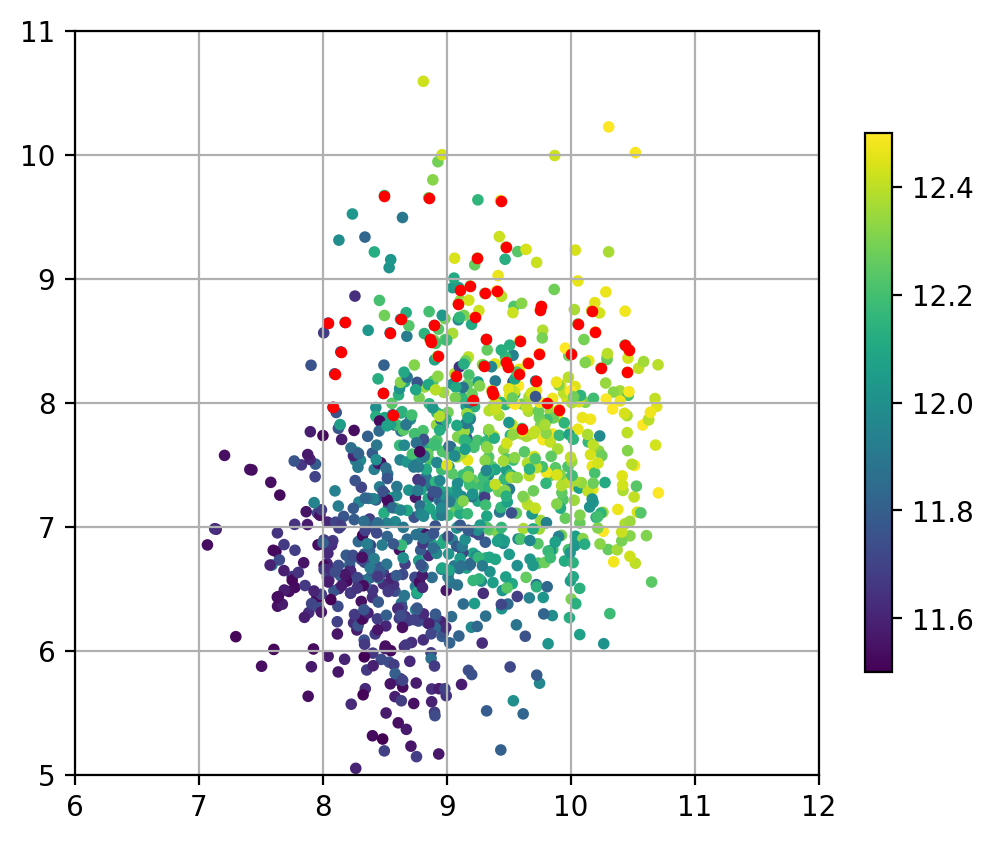

In [261]:
# Could put MW on here

pl.figure(figsize=(6,5))
sm = pl.scatter(np.log10(m_acc),np.log10(m_streams),s=10,c=np.log10(root_mass))
pl.scatter(np.log10(m_acc[tree_has_sgr]),np.log10(m_streams[tree_has_sgr]),s=10,c='r')

pl.axis('square')
pl.xlim(6,12)
pl.ylim(5,11)
pl.colorbar(sm,shrink=0.7)
pl.grid()

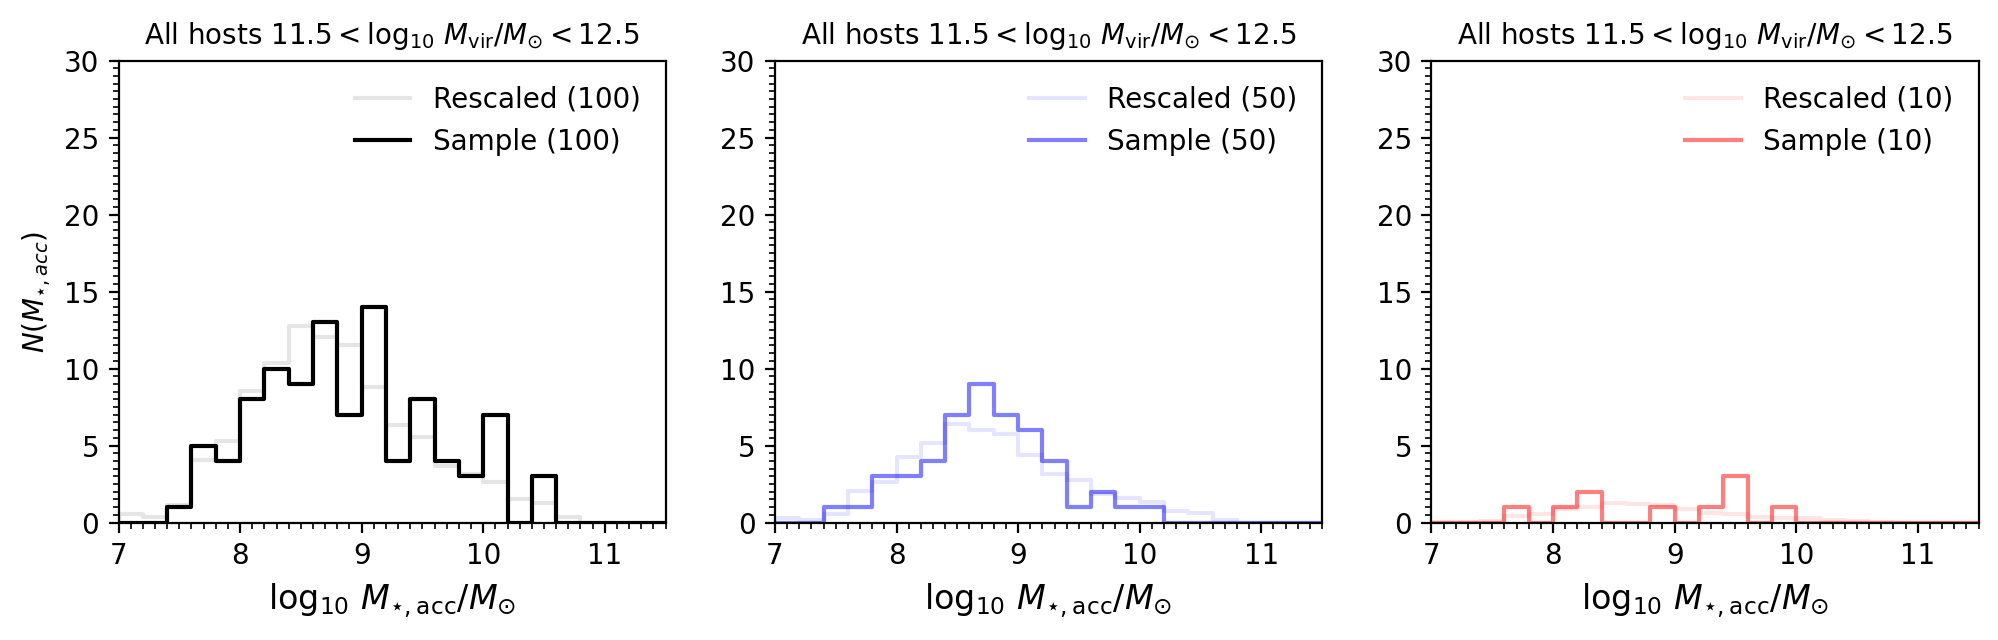

In [262]:
# Convert to actual number in a sample of 100 objects
np.random.seed(42)

def _decorate(ax):
    ax = pl.gca()
    pl.xlim(7,11.5)
    pl.legend(frameon=False,loc='upper right')
    pl.title(r'All hosts $11.5<\log_{{10}}\,M_\mathrm{{vir}}/M_{{\odot}}<12.5$'.format(s.sum()),
             fontsize=10)
    small_tickmarks(ax,0.1,0.5)
    pl.xlabel("$\log_{10}\,M_\mathrm{\star,acc}/M_{\odot}$",fontsize=12);
    
pl.figure(figsize=(12,3))

# Normalize weights to sum to 1
probabilities = weights / np.sum(weights)

# Total histogram
h_all,b = np.histogram(np.log10(m_acc),bins=np.arange(5,13,0.2),weights=weights)

## 100 Draws
ax = pl.subplot(1,3,1)

F = 100/np.sum(weights)
pl.plot(b[:-1],h_all*F,color='k',alpha=.1,drawstyle='steps-post',label='Rescaled (100)');

# Draw 100 unique indices (without replacement) using the weights as probabilities
r = np.random.choice(len(weights), size=100, replace=False, p=probabilities)
h,b = np.histogram(np.log10(m_acc[r]+m_streams[r]),bins=np.arange(5,13,0.2))
pl.plot(b[:-1],h,color='k',alpha=1,lw=1.5,drawstyle='steps-post',label='Sample (100)');

_decorate(ax)
pl.ylim(0,30)
pl.ylabel('$N(M_{\star,acc})$')

## 50 Draws
ax = pl.subplot(1,3,2)

F = 50/np.sum(weights)
pl.plot(b[:-1],h_all*F,color='b',alpha=.1,drawstyle='steps-post',label='Rescaled (50)');

# Draw 50 unique indices (without replacement) using the weights as probabilities
r = np.random.choice(len(weights), size=50, replace=False, p=probabilities)
h,b = np.histogram(np.log10(m_acc[r]+m_streams[r]),bins=np.arange(5,13,0.2))
pl.plot(b[:-1],h,color='b',alpha=0.5,drawstyle='steps-post',label='Sample (50)');

_decorate(ax)
pl.ylim(0,30)

## 10 Draws
ax = pl.subplot(1,3,3)

F = 10/np.sum(weights)
pl.plot(b[:-1],h_all*F,color='r',alpha=.1,drawstyle='steps-post',label='Rescaled (10)');

# Draw 10 unique indices (without replacement) using the weights as probabilities
r = np.random.choice(len(weights), size=10, replace=False, p=probabilities)
h,b = np.histogram(np.log10(m_acc[r]+m_streams[r]),bins=np.arange(5,13,0.2))
pl.plot(b[:-1],h,color='r',alpha=0.5,drawstyle='steps-post',label='Sample (10)');

_decorate(ax)
pl.ylim(0,30)

path = './figs/mvir_macc_distribution_sampled_logmass_range_set.png'
pl.savefig(path,bbox_inches='tight',pad_inches=0.1,dpi=300)

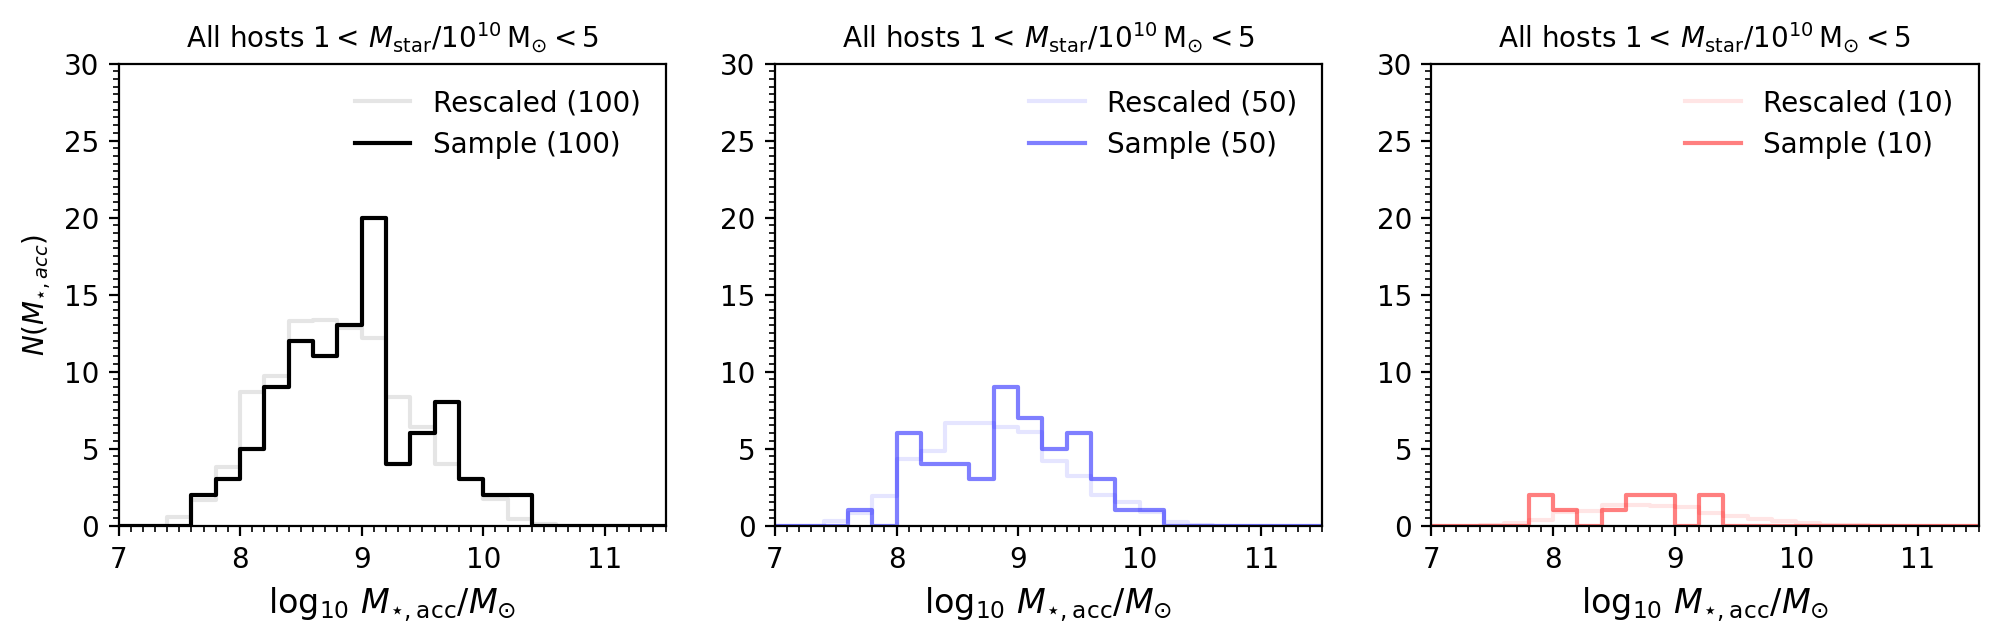

In [263]:
# Convert to actual number in a sample of 100 objects
np.random.seed(42)

def _decorate(ax):
    ax = pl.gca()
    pl.xlim(7,11.5)
    pl.legend(frameon=False,loc='upper right')
    pl.title(r'All hosts $1<\,M_\mathrm{{star}}/10^{{10}}\,\mathrm{{M}}_{{\odot}}<5$'.format(s.sum()),
             fontsize=10)
    small_tickmarks(ax,0.1,0.5)
    pl.xlabel("$\log_{10}\,M_\mathrm{\star,acc}/M_{\odot}$",fontsize=12);
    
pl.figure(figsize=(12,3))

s = mw_by_mstar_all_in
# Normalize weights to sum to 1
probabilities = weights[s] / np.sum(weights[s])

# Total histogram
h_all,b = np.histogram(np.log10(m_acc[s]),bins=np.arange(5,13,0.2),weights=weights[s])

## 100 Draws
ax = pl.subplot(1,3,1)

F = 100/np.sum(weights[s])
pl.plot(b[:-1],h_all*F,color='k',alpha=.1,drawstyle='steps-post',label='Rescaled (100)');

# Draw 100 unique indices (without replacement) using the weights as probabilities
r = np.random.choice(len(weights[s]), size=100, replace=False, p=probabilities)
h,b = np.histogram(np.log10(m_acc[s][r]+m_streams[s][r]),bins=np.arange(5,13,0.2))
pl.plot(b[:-1],h,color='k',alpha=1,lw=1.5,drawstyle='steps-post',label='Sample (100)');

_decorate(ax)
pl.ylim(0,30)
pl.ylabel('$N(M_{\star,acc})$')

## 50 Draws
ax = pl.subplot(1,3,2)

F = 50/np.sum(weights[s])
pl.plot(b[:-1],h_all*F,color='b',alpha=.1,drawstyle='steps-post',label='Rescaled (50)');

# Draw 50 unique indices (without replacement) using the weights as probabilities
r = np.random.choice(len(weights[s]), size=50, replace=False, p=probabilities)
h,b = np.histogram(np.log10(m_acc[s][r]+m_streams[s][r]),bins=np.arange(5,13,0.2))
pl.plot(b[:-1],h,color='b',alpha=0.5,drawstyle='steps-post',label='Sample (50)');

_decorate(ax)
pl.ylim(0,30)

## 10 Draws
ax = pl.subplot(1,3,3)

F = 10/np.sum(weights[s])
pl.plot(b[:-1],h_all*F,color='r',alpha=.1,drawstyle='steps-post',label='Rescaled (10)');

# Draw 10 unique indices (without replacement) using the weights as probabilities
r = np.random.choice(len(weights[s]), size=10, replace=False, p=probabilities)
h,b = np.histogram(np.log10(m_acc[s][r]+m_streams[s][r]),bins=np.arange(5,13,0.2))
pl.plot(b[:-1],h,color='r',alpha=0.5,drawstyle='steps-post',label='Sample (10)');

_decorate(ax)
pl.ylim(0,30)

path = './figs/mvir_macc_distribution_sampled_logmass_range_set_mw_by_mstar.png'
pl.savefig(path,bbox_inches='tight',pad_inches=0.1,dpi=300)

In [264]:
nsamples = 10000

def sample_quantiles(values, weights, probabilities, nsize=100, nsamples=10000):
    """
    """
    p10 = np.zeros(nsamples)
    p50 = np.zeros(nsamples)
    p90 = np.zeros(nsamples)
    for i in range(0,nsamples):
        r = np.random.choice(len(weights), size=nsize, replace=True, p=probabilities)
        p10[i],p50[i],p90[i] = weighted_quantile(np.log10(values[r]),[0.1,0.5,0.9],sample_weight=weights[r])
    return p10,p50,p90 

(1.0, 2.0)

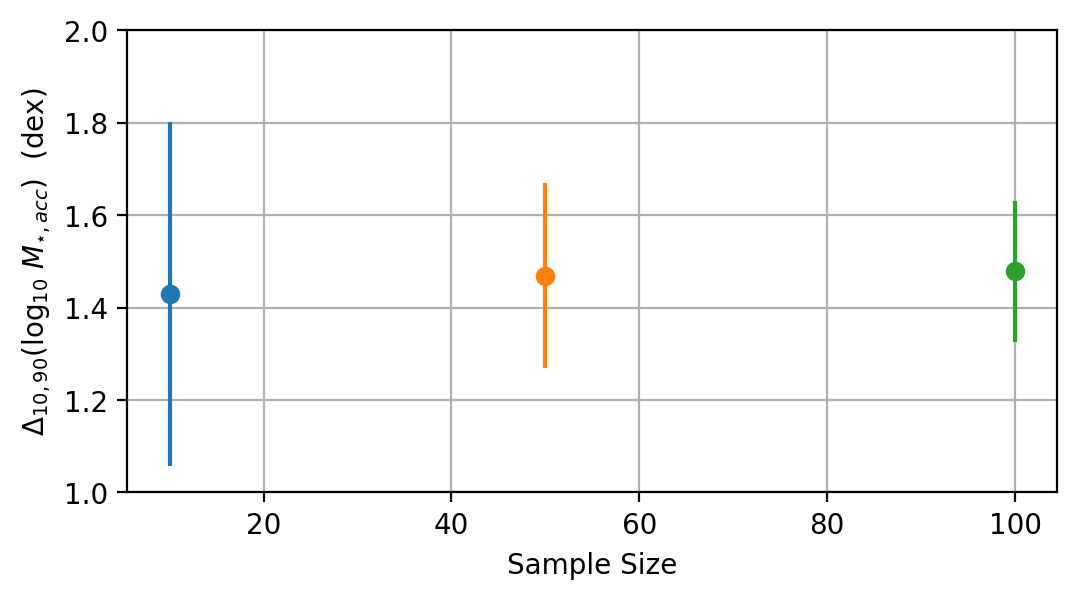

In [265]:
pl.figure(figsize=(6,3))

# Normalize weights to sum to 1
probabilities = weights / np.sum(weights)

for nsize in [10,50,100]:
    p10,p50,p90 = sample_quantiles(m_acc+m_streams,
                                   weights,
                                   probabilities,
                                   nsize=nsize)
    mean_1090   = np.mean(p90-p10)
    std_1090    = np.std(p90-p10)
    pl.errorbar(nsize, mean_1090, yerr=std_1090, marker='o')
        
pl.xlabel('Sample Size')
pl.ylabel('$\Delta_{10,90}(\log_{10}\,M_{\star,acc})$  (dex)')
pl.grid()
pl.ylim(1,2)

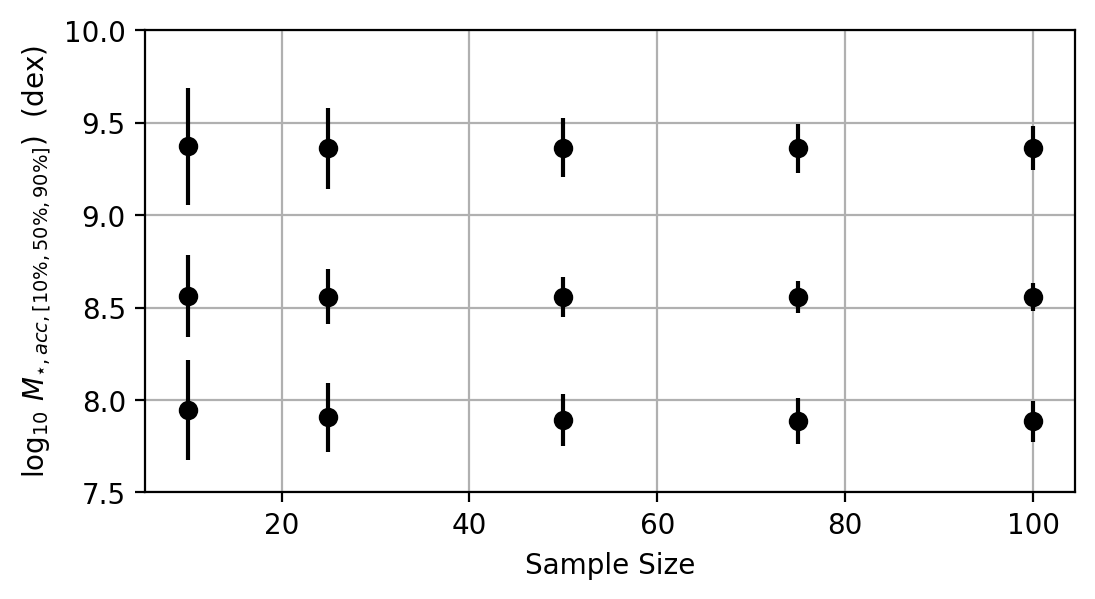

In [266]:
pl.figure(figsize=(6,3))

probabilities = weights / np.sum(weights)

for nsize in [10,25,50,75,100]:
    p10,p50,p90 = sample_quantiles(m_acc+m_streams,
                                   weights,
                                   probabilities,
                                   nsize=nsize)
    pl.errorbar(nsize, np.mean(p10), yerr=np.std(p10), marker='o',c='k')
    pl.errorbar(nsize, np.mean(p50), yerr=np.std(p50), marker='o',c='k')
    pl.errorbar(nsize, np.mean(p90), yerr=np.std(p90), marker='o',c='k')

pl.xlabel('Sample Size')
pl.ylabel('$\log_{10}\,M_{\star,acc,[10\%,50\%,90\%]})$  (dex)')
pl.grid()
pl.ylim(7.5,10.0)

path = './figs/mvir_macc_estimate_quantiles_logmass_range_set.png'
pl.savefig(path,bbox_inches='tight',pad_inches=0.1,dpi=300)

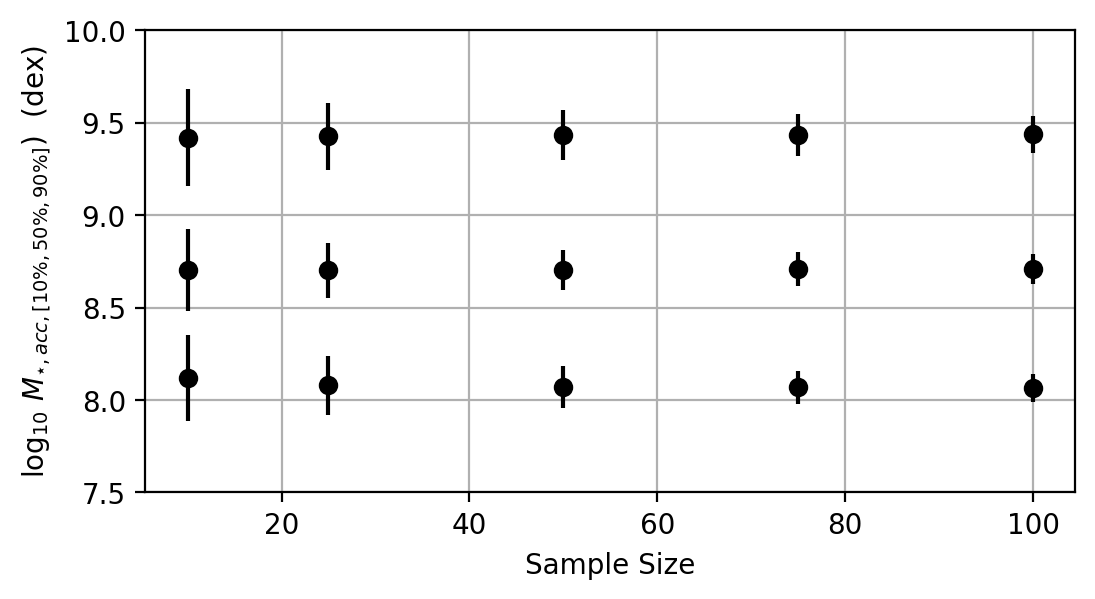

In [267]:
pl.figure(figsize=(6,3))

s = mw_by_mstar_all_in
# Normalize weights to sum to 1
probabilities = weights[s] / np.sum(weights[s])

for nsize in [10,25,50,75,100]:
    p10,p50,p90 = sample_quantiles(m_acc[s]+m_streams[s],
                                   weights[s],
                                   probabilities,
                                   nsize=nsize)
    pl.errorbar(nsize, np.mean(p10), yerr=np.std(p10), marker='o',c='k')
    pl.errorbar(nsize, np.mean(p50), yerr=np.std(p50), marker='o',c='k')
    pl.errorbar(nsize, np.mean(p90), yerr=np.std(p90), marker='o',c='k')

pl.xlabel('Sample Size')
pl.ylabel('$\log_{10}\,M_{\star,acc,[10\%,50\%,90\%]})$  (dex)')
pl.grid()
pl.ylim(7.5,10.0)

path = './figs/mvir_macc_estimate_quantiles_logmass_range_set_mw_by_mstar.png'
pl.savefig(path,bbox_inches='tight',pad_inches=0.1,dpi=300)

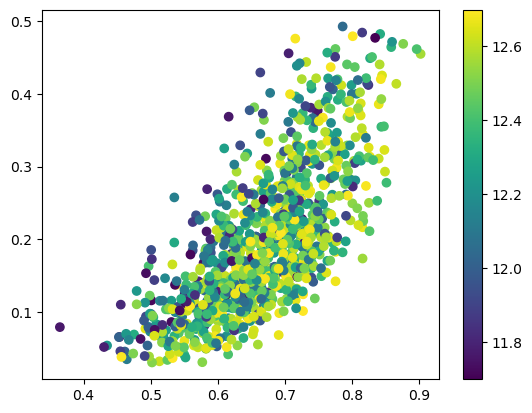

In [1183]:
pl.scatter((tree_tot_prog_mass_frac),(tree_max_prog_mass_frac),
           c=np.log10(root_mass));
pl.colorbar()

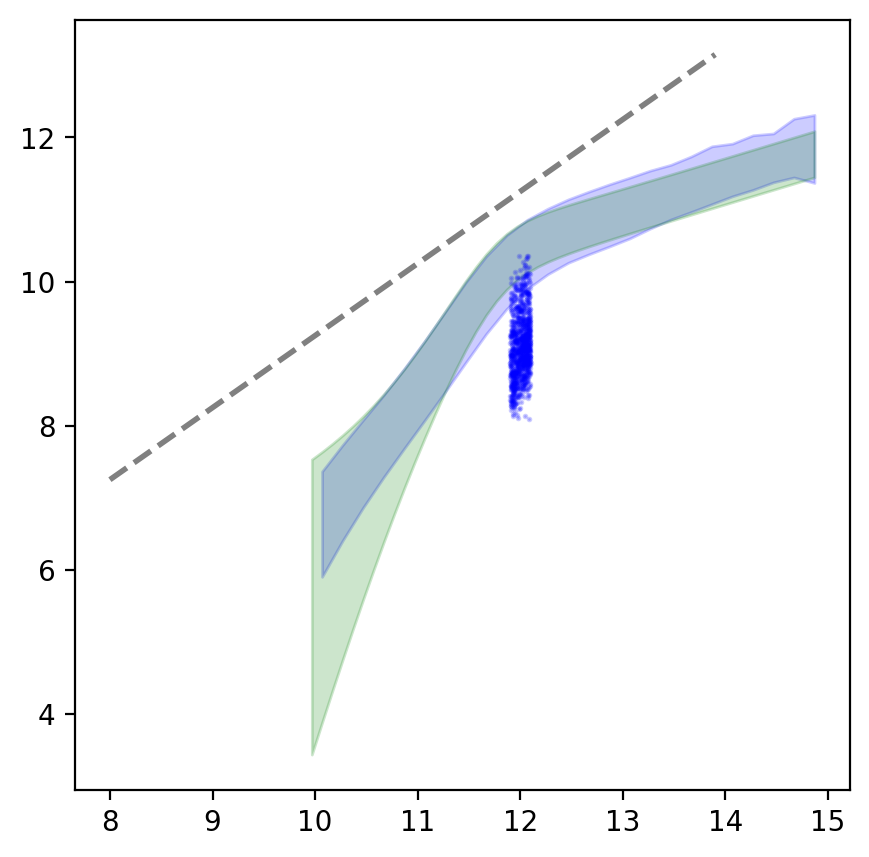

In [71]:
pl.figure(figsize=(5,5))

pl.scatter(np.log10(root_mass),np.log10(m_acc+m_streams),s=1,c='b',alpha=0.2)

OMEGA_B = 0.04455
OMEGA_0 = 0.25
baryon_mass_fraction = OMEGA_B/OMEGA_0 
xx = np.arange(8,14,0.1)
yy = xx+np.log10(baryon_mass_fraction)
pl.plot(xx,yy,c='grey',lw=2,ls='--')

ax = pl.gca()
plot_b18(ax,c='b',h=0.73)
plot_m18(ax,c='g',h=0.73)


(array([  5.,  44., 120., 162., 219., 185., 116.,  79.,  53.,  17.]),
 array([ 7.83060525,  8.0831426 ,  8.33567995,  8.5882173 ,  8.84075466,
         9.09329201,  9.34582936,  9.59836671,  9.85090407, 10.10344142,
        10.35597877]),
 <BarContainer object of 10 artists>)

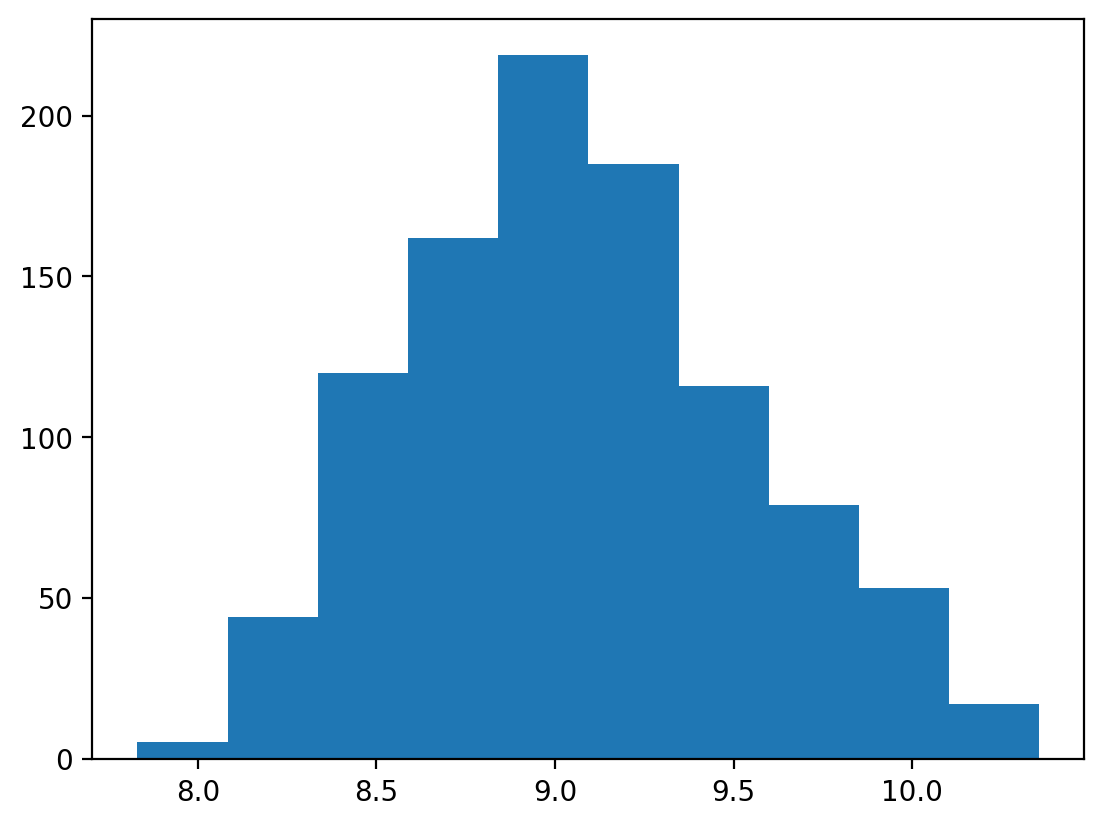

In [73]:
pl.hist(np.log10(m_acc))

(-1.0, 3.5)

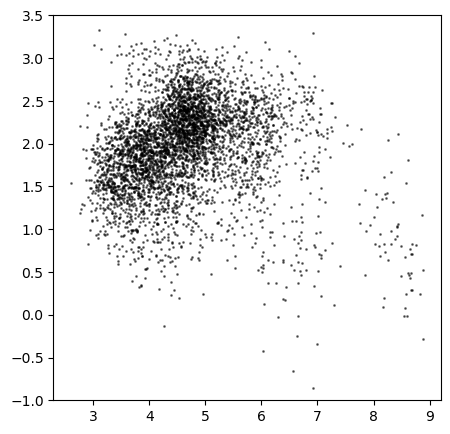

In [530]:
pl.figure(figsize=(5,5))

itree  = 0

for itree in range(0,ntrees):
    mstar_fin_all = results[itree]['final_mstar']
    mstar_ini_all = results[itree]['initial_mstar']
    mass_fin_all  = results[itree]['final_mass']
    mass_ini_all  = results[itree]['initial_mass']
    r_fin_all     = results[itree]['final_radius']

    pl.scatter(np.log10(mstar_ini_all), np.log10(r_fin_all), s=1, c='k', alpha=0.5)
pl.ylim(-1,3.5)

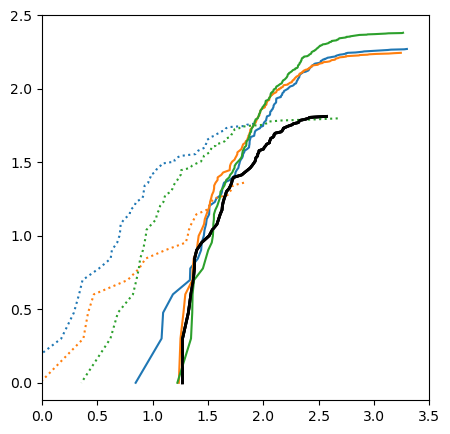

In [787]:
pl.figure(figsize=(5,5))

itree  = 0

for itree in range(0,3):
    mstar_fin_all = results[itree]['final_mstar']
    mstar_ini_all = results[itree]['initial_mstar']
    mass_fin_all  = results[itree]['final_mass']
    mass_ini_all  = results[itree]['initial_mass']

    r_fin_all = results[itree]['final_radius']

    f_star_bound = mstar_fin_all/mstar_ini_all
    f_mass_bound = mass_fin_all/mass_ini_all

    survives     = (mass_fin_all > cfg.Mres) & (f_mass_bound > cfg.psi_res)

    x  = r_fin_all[survives]
    nx = len(x)
    x_sort = np.argsort(x)[::-1]
    _p = pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)))
    _c = _p[0].get_c()

    x  = r_fin_all[~survives]
    nx = len(x)
    x_sort = np.argsort(x)[::-1]
    _p = pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),ls=':',c=_c)
    
    x  = mw_sats_rgc
    nx = len(x)
    x_sort = np.argsort(x)[::-1]
    _p = pl.plot(np.log10(x[x_sort]),np.log10(np.arange(nx,0,-1)),ls='solid',c='k',lw=2)
    
    pl.xlim(0,3.5)

### Dask

In [837]:
client = Client()

In [842]:
print(client)

<Client: 'tcp://127.0.0.1:36520' processes=2 threads=2, memory=128.00 GiB>


In [868]:
from dask.distributed import Client, LocalCluster

# LocalCluster([name, n_workers, ...])

In [871]:
cluster = LocalCluster('MyCluster',n_workers=2,threads_per_worker=1,processes=True)
client = Client()
print(client)

<Client: 'tcp://127.0.0.1:40988' processes=2 threads=2, memory=128.00 GiB>


In [874]:
import time

In [875]:
client.scatter(

In [816]:
from dask.distributed import Client

client = Client(n_workers=2)
print(client)



In [817]:
def process_tree(itree,
                 progenitors=None,
                 tree_main_branch_masses=None,
                 tree_redshifts=None,
                 cosmology=None):
    """
    """
    # SATGEN.cfg implicitly sets resolution limits on mass (absolute and relative) and radius
    # Set them explicitly here; these are the degaults
    cfg.Mres    = 100.0
    cfg.Rres    = 0.001
    cfg.psi_res = 1.0e-5

    np.random.seed(42)
    
    progs_this_tree   = np.flatnonzero(progenitors['TreeID'] == itree)
    nprogs_this_tree  = len(progs_this_tree)
    host_mass_history = tree_main_branch_masses[itree]
    
    results = dict()
    
    results['initial_mass']  = list()
    results['initial_mstar'] = list()
    
    results['final_mass']   = list()
    results['final_mstar']  = list()
    results['final_radius'] = list()
    
    for iprog in range(0,nprogs_this_tree):
        prog_z    = progenitors['ProgenitorZred'][iprog]
        prog_mass = progenitors['ProgenitorMass'][iprog]
        t, r, o, pm, pmstar = compute_orbit_radius(host_mass_history,prog_z,prog_mass,
                                                   host_mass_z = tree_redshifts,
                                                   orbit_init_method = 'li2020',
                                                   cosmology = cosmology,
                                                   evolve_prog_mass = True)
        
        #results['initial_mass'].append(_o)
        results['initial_mass'].append(pm[0])
        results['final_mass'].append(pm[-1])
        
        results['initial_mstar'].append(pmstar[0])
        results['final_mstar'].append(pmstar[-1])
        results['final_radius'].append(r[-1])

    for k in results.keys():
        results[k] = np.array(results[k])
        
    results['nprog'] = len(results['initial_mass'])
        
    return results

In [835]:
def write_results(results, filename):
    """
    """
    import h5py
    data_keys = results[0].keys()

    total_results = dict()
    for k in data_keys:
        total_results[k] = list()
    total_results['tree_idx'] = list()

    for itree in range(0,3):
        for k in data_keys:
            total_results[k].append(np.atleast_1d(results[itree][k]))
        total_results['tree_idx'].append(np.repeat(itree,results[itree]['nprog']))

    for k in total_results.keys():
        print(k)
        total_results[k] = np.concatenate(total_results[k])

    total_nprog = len(total_results['tree_idx'])

    with h5py.File(filename, "w") as f:
        f["/"].create_group('Progenitors')
        for k, v in total_results.items():
            f["/Progenitors"].create_dataset(k, data=v, compression=6) 
            
    print('Wrote {:s}'.format(filename))
    return

In [818]:
futures = client.map(process_tree, range(3),
                    progenitors=progenitors,
                    tree_main_branch_masses=tree_main_branch_masses,
                    tree_redshifts=tree_redshifts,
                    cosmology=cosmology)

In [819]:
results = client.gather(futures)

/data/apcooper/sfw/SatGen/galhalo.py:92: RuntimeWarning: overflow encountered in exp
  return delta*(np.log10(1.+np.exp(x)))**gamma/(1.+np.exp(10**(-x)))-\
/data/apcooper/sfw/SatGen/galhalo.py:92: RuntimeWarning: overflow encountered in exp
  return delta*(np.log10(1.+np.exp(x)))**gamma/(1.+np.exp(10**(-x)))-\


In [836]:
write_results(results, 'all_progenitors.hdf5')

initial_mass
initial_mstar
final_mass
final_mstar
final_radius
nprog
tree_idx
Wrote all_progenitors.hdf5


In [ ]:
# cosmology = cosmo.Planck18

# Millennium
hubble_parameter = 0.73

cosmology = cosmo.FlatLambdaCDM(hubble_parameter*100,0.25)

tree_file = './satgen_pchtrees/output_satgen.hdf5'

tree_main_branch_masses = read_pchtrees_main_branch_mass(tree_file)
tree_main_branch_masses = tree_main_branch_masses/hubble_parameter

ntrees, nlev = tree_main_branch_masses.shape

progenitors = read_pchtrees_progenitors(tree_file)
progenitors['ProgenitorMass'] = progenitors['ProgenitorMass']/hubble_parameter
progenitors['HostMass']       = progenitors['HostMass']/hubble_parameter

tree_redshifts = read_pchtrees_redshifts(tree_file)
tree_t_lbk_gyr = cosmology.lookback_time(tree_redshifts).value
tree_t_age_gyr = cosmology.age(tree_redshifts).value

np.random.seed(42)

results = dict()

for itree in range(0,ntrees):
    progs_this_tree   = np.flatnonzero(progenitors['TreeID'] == itree)
    nprogs_this_tree  = len(progs_this_tree)
    host_mass_history = tree_main_branch_masses[itree]
        
    print(f'Tree {itree:d}, Progenitors: {nprogs_this_tree:d}')

    results[itree] = dict()
    
    results[itree]['initial_mass']  = list()
    results[itree]['initial_mstar'] = list()
    
    results[itree]['final_mass']   = list()
    results[itree]['final_mstar']  = list()
    results[itree]['final_radius'] = list()

    for iprog in range(0,nprogs_this_tree):
        prog_z    = progenitors['ProgenitorZred'][iprog]
        prog_mass = progenitors['ProgenitorMass'][iprog]
        eps       = 0.5
        t, r, o, pm, pmstar = compute_orbit_radius(host_mass_history,prog_z,prog_mass,
                                                   host_mass_z = tree_redshifts,
                                                   orbit_init_method='li2020',
                                                   cosmology=cosmology,
                                                   evolve_prog_mass = True,
                                                   eps=eps,xc=1)
        
        results[itree]['initial_mass'].append(pm[0])
        results[itree]['final_mass'].append(pm[-1])
        
        results[itree]['initial_mstar'].append(pmstar[0])
        results[itree]['final_mstar'].append(pmstar[-1])
        results[itree]['final_radius'].append(r[-1])

    for k in results[itree].keys():
        results[itree][k] = np.array(results[itree][k])